In [1]:
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import neurokit2 as nk
from scipy.signal import butter, filtfilt
from scipy.signal import resample
from scipy import stats

In [2]:
CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/dataset/'

In [3]:
# Load the dataset
file_path = DATA_DIR + 'fantasia_dataset.plk'
df = pd.read_pickle(file_path)
df

,ecg,resp,subject_id,sample,sample_rate
0,7.952000,8.000000,f1y01,0,250
1,7.936000,8.044000,f1y01,1,250
2,8.004000,8.000000,f1y01,2,250
3,8.064000,8.052000,f1y01,3,250
4,7.980000,8.012000,f1y01,4,250
...,...,...,...,...,...
71796331,-0.335693,0.457764,f2o08,1757117,250
71796332,-0.286865,0.445557,f2o08,1757118,250
71796333,-0.244141,0.445557,f2o08,1757119,250
71796334,-0.256348,0.433350,f2o08,1757120,250


In [4]:
# Need to resample 'f2y02' from 333 Hz to 250 Hz
subject_id = 'f2y02'
original_sample_rate = df[df['subject_id'] == subject_id]['sample_rate'].iloc[0]
target_sample_rate = 250

downsample_factor = target_sample_rate / original_sample_rate
n_samples = int(len(df[df['subject_id'] == subject_id]) * downsample_factor)

# Filter the DataFrame
df_subject = df[df['subject_id'] == subject_id].copy()
df_new = pd.DataFrame(columns=df_subject.columns.to_list())

# Downsample the 'ecg' and 'resp' columns

df_new['ecg'] = resample(df_subject['ecg'], n_samples)
df_new['resp'] = resample(df_subject['resp'], n_samples)
df_new['subject_id'] = df_subject['subject_id'].iloc[0]
df_new['sample_rate'] = target_sample_rate
df_new['sample'] = df_new.index.to_list()

#replace value
df = df[df['subject_id'] != subject_id]
df = pd.concat([df,df_new],ignore_index=True).reset_index(drop=True)
# # Verify the update
# print(df[df['subject_id'] == subject_id])

In [5]:
df

,ecg,resp,subject_id,sample,sample_rate
0,7.952000,8.000000,f1y01,0,250
1,7.936000,8.044000,f1y01,1,250
2,8.004000,8.000000,f1y01,2,250
3,8.064000,8.052000,f1y01,3,250
4,7.980000,8.012000,f1y01,4,250
...,...,...,...,...,...
71212457,-0.059550,0.136491,f2y02,1758649,250
71212458,-0.064602,0.141801,f2y02,1758650,250
71212459,-0.057322,0.136319,f2y02,1758651,250
71212460,-0.051296,0.143035,f2y02,1758652,250


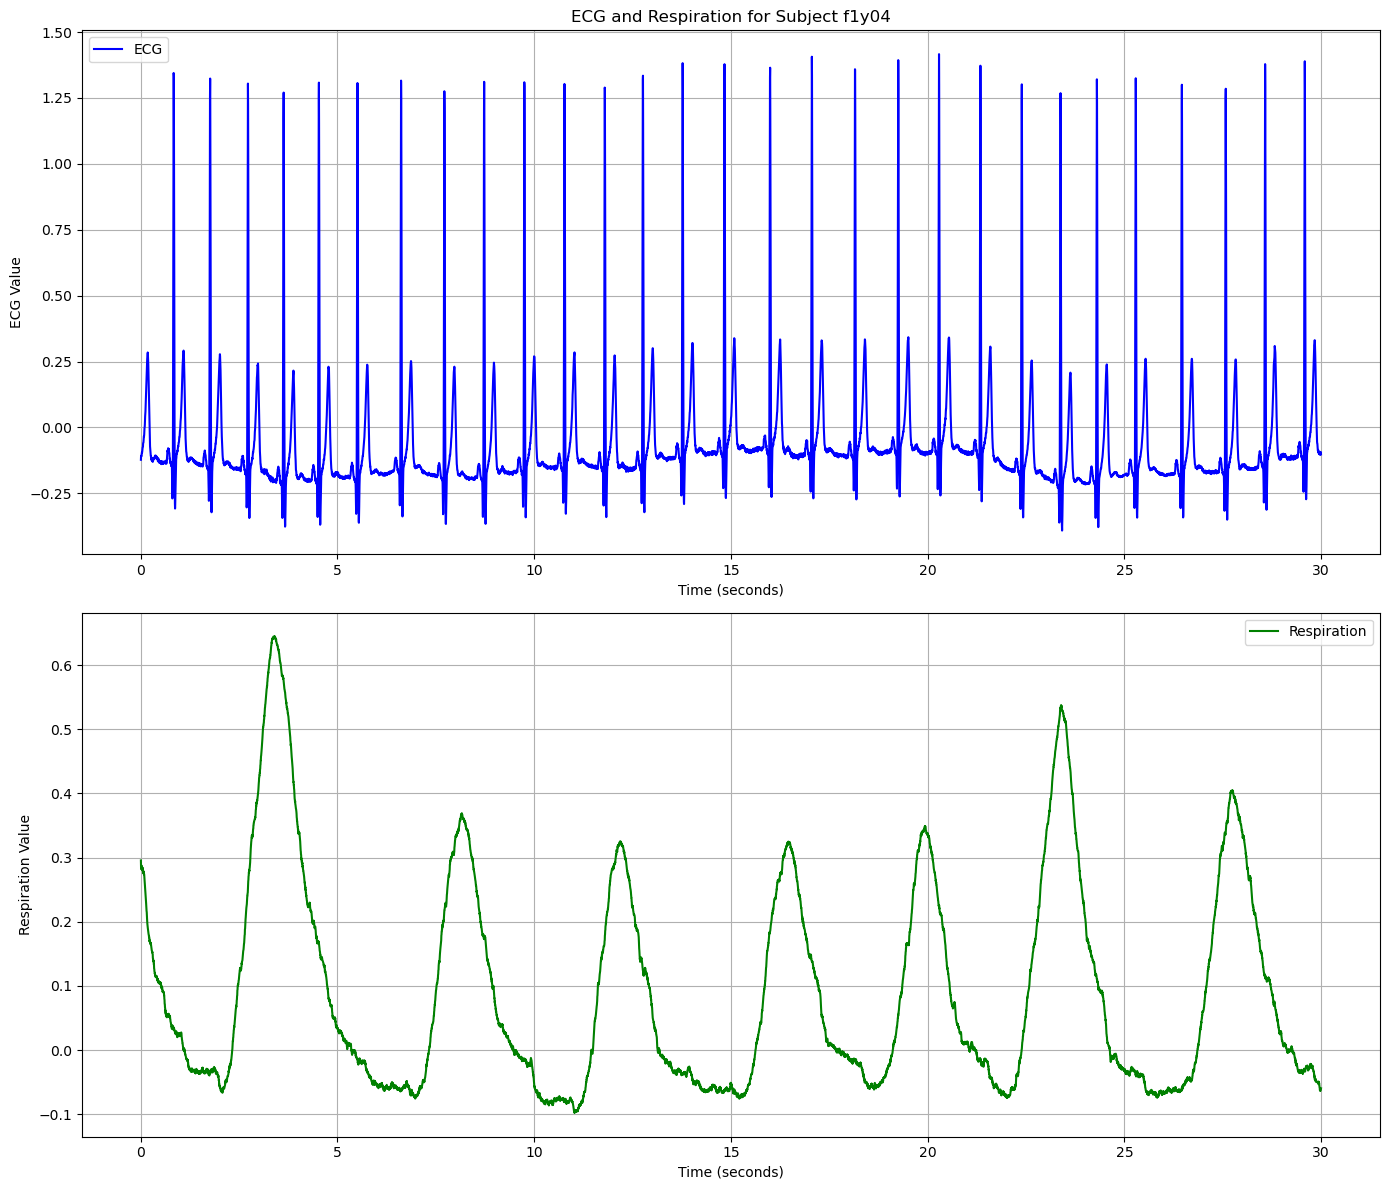

In [6]:

# Group by subject_id and choose one random subject
grouped = df.groupby('subject_id')
random_subject = np.random.choice(df['subject_id'].unique())

# Filter the dataframe for the chosen subject
#subject_df = grouped.get_group(random_subject)
subject_df = grouped.get_group('f2y02')

# Convert samples to seconds
sample_rate = 250  # 250 samples per second
time_in_seconds = subject_df['sample'].iloc[1:7500] / sample_rate

# Plot the data
plt.figure(figsize=(14, 12))

# Plot ECG data
plt.subplot(2, 1, 1)
plt.plot(time_in_seconds, subject_df['ecg'].iloc[1:7500], label='ECG', color='blue')
plt.title(f'ECG and Respiration for Subject {random_subject}')
plt.xlabel('Time (seconds)')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True)

# Plot respiration data
plt.subplot(2, 1, 2)
plt.plot(time_in_seconds, subject_df['resp'].iloc[1:7500], label='Respiration', color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Respiration Value')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

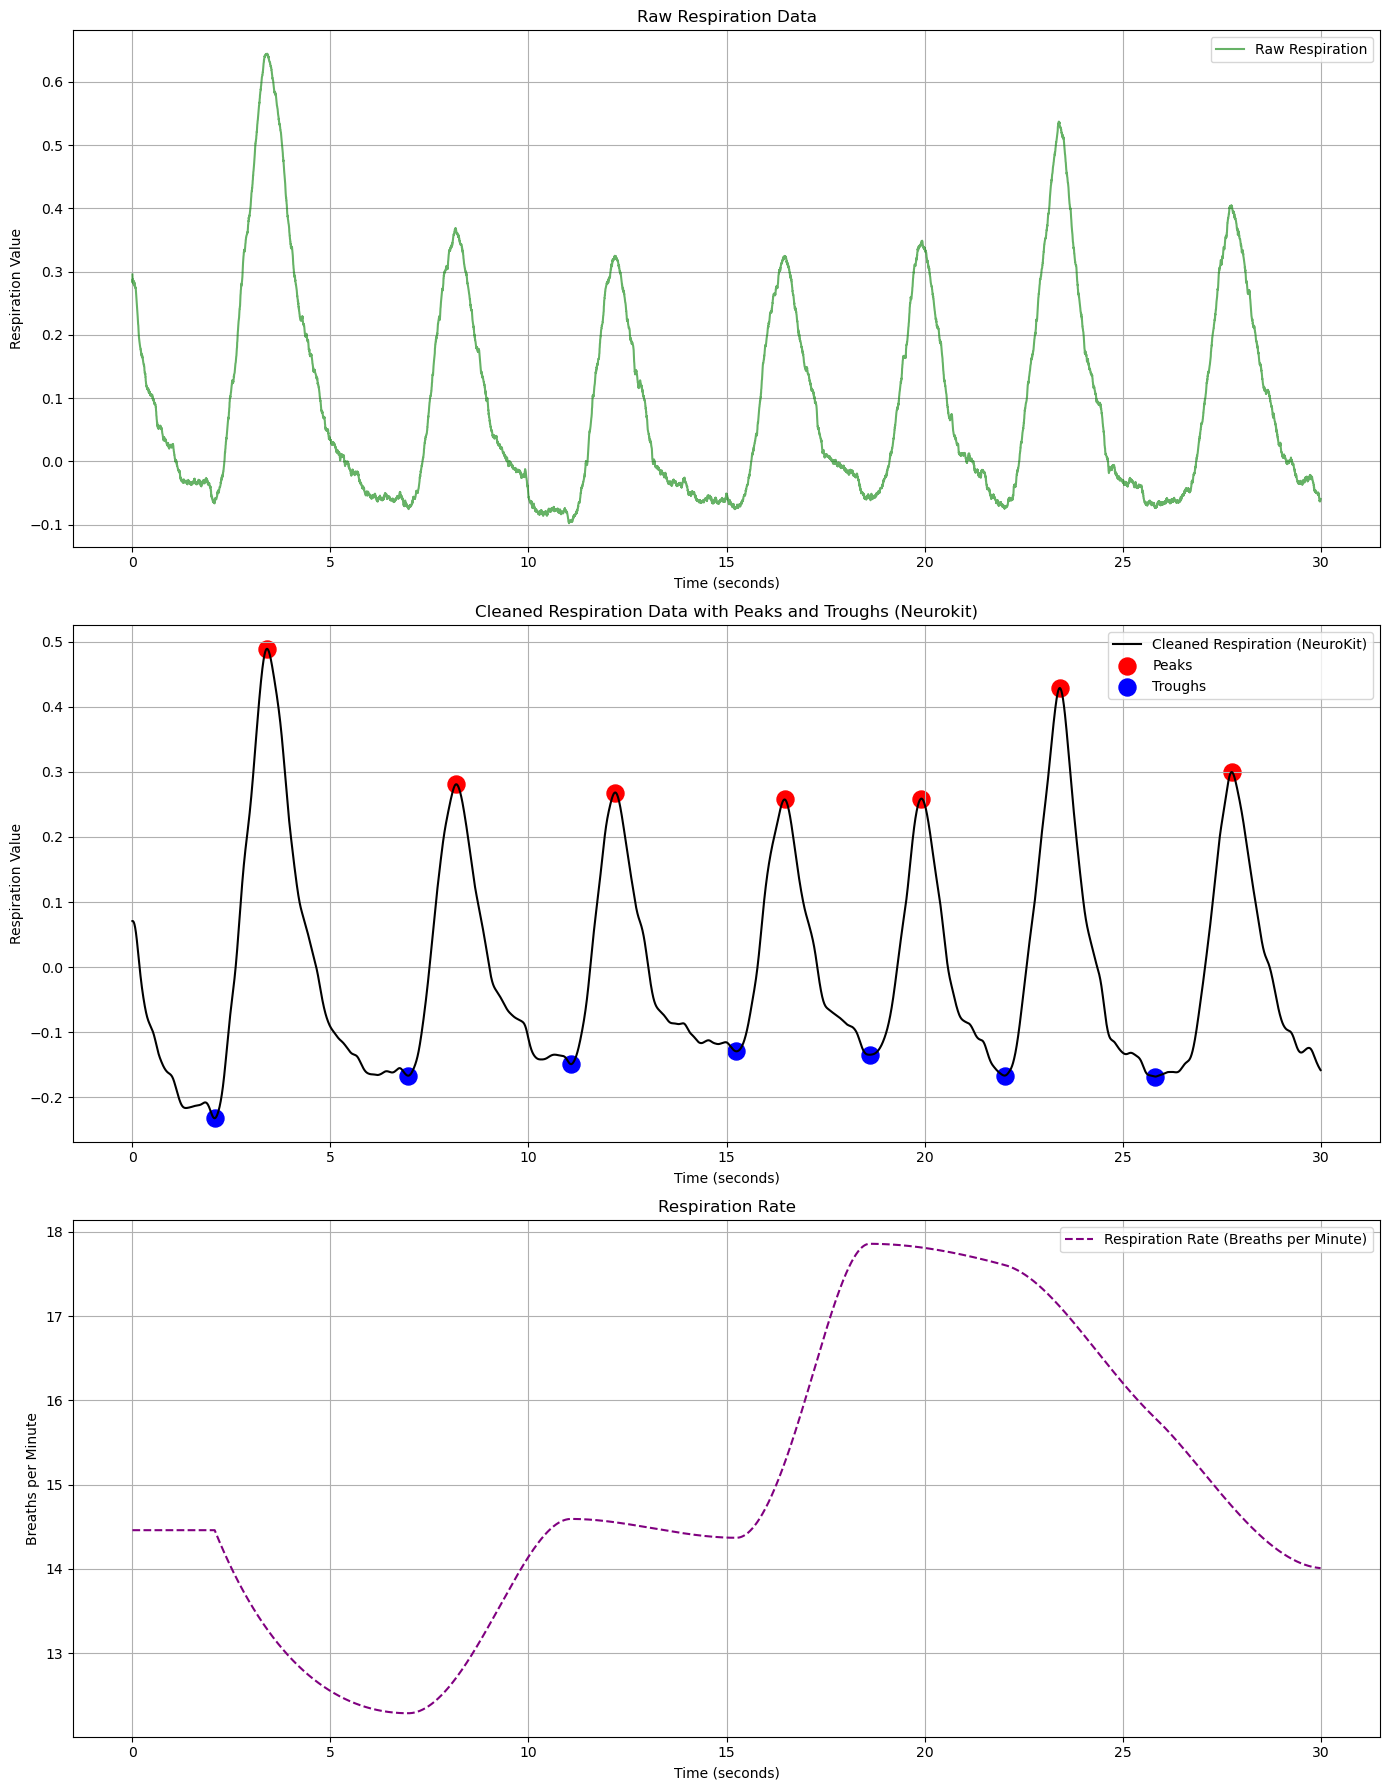

In [7]:
# Ensure the indices for slicing are within the bounds of the DataFrame
sample_rate = 250  # 250 samples per second
start_index = 1
end_index = min(7500, len(subject_df))

# Convert samples to seconds
time_in_seconds = subject_df['sample'].iloc[start_index:end_index] / sample_rate

# Respiration data for the selected range
respiration = subject_df['resp'].iloc[start_index:end_index]

# Clean and process the respiration data using nk.rsp_process
rsp_signals, rsp_info = nk.rsp_process(subject_df['resp'], sampling_rate=sample_rate, method='khodadad2018')

# Extract the cleaned respiration signal, peaks, troughs, and respiration rate
cleaned_respiration = rsp_signals["RSP_Clean"].iloc[start_index:end_index]
peaks = rsp_signals["RSP_Peaks"].iloc[start_index:end_index].values
troughs = rsp_signals["RSP_Troughs"].iloc[start_index:end_index].values
respiration_rate = rsp_signals["RSP_Rate"].iloc[start_index:end_index].values

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 18))

# Plot raw respiration data
axs[0].plot(time_in_seconds, respiration, label='Raw Respiration', color='green', alpha=0.6)
axs[0].set_title('Raw Respiration Data')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Respiration Value')
axs[0].legend()
axs[0].grid(True)

# Plot cleaned respiration data with peaks and troughs
axs[1].plot(time_in_seconds, cleaned_respiration, label='Cleaned Respiration (NeuroKit)', color='black')
axs[1].scatter(time_in_seconds[peaks == 1], cleaned_respiration[peaks == 1], color='red', marker='o', s=150, label='Peaks')
axs[1].scatter(time_in_seconds[troughs == 1], cleaned_respiration[troughs == 1], color='blue', marker='o', s=150, label='Troughs')
axs[1].set_title('Cleaned Respiration Data with Peaks and Troughs (Neurokit)')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Respiration Value')
axs[1].legend()
axs[1].grid(True)

# Plot respiration rate
axs[2].plot(time_in_seconds, respiration_rate, label='Respiration Rate (Breaths per Minute)', color='purple', linestyle='--')
axs[2].set_title('Respiration Rate')
axs[2].set_xlabel('Time (seconds)')
axs[2].set_ylabel('Breaths per Minute')
axs[2].legend()
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
rsp_signals

,RSP_Raw,RSP_Clean,RSP_Amplitude,RSP_Rate,RSP_RVT,RSP_Phase,RSP_Phase_Completion,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Peaks,RSP_Troughs
0,0.272499,0.070706,0.721436,14.457910,0.045393,NaN,0.0,0.740522,0.270270,0,0
1,0.295558,0.070791,0.721436,14.457910,0.045401,NaN,0.0,0.740522,0.270270,0,0
2,0.282928,0.070825,0.721436,14.457910,0.045410,NaN,0.0,0.740522,0.270270,0,0
3,0.288274,0.070801,0.721436,14.457910,0.045420,NaN,0.0,0.740522,0.270270,0,0
4,0.282781,0.070713,0.721436,14.457910,0.045431,NaN,0.0,0.740522,0.270270,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1758649,0.136491,0.003134,0.461045,7.194245,0.146534,NaN,0.0,0.626943,0.154436,0,0
1758650,0.141801,0.002736,0.461045,7.194245,0.146583,NaN,0.0,0.626943,0.154436,0,0
1758651,0.136319,0.002366,0.461045,7.194245,0.146631,NaN,0.0,0.626943,0.154436,0,0
1758652,0.143035,0.002024,0.461045,7.194245,0.146679,NaN,0.0,0.626943,0.154436,0,0


In [9]:
subject_df

,ecg,resp,subject_id,sample,sample_rate
69453808,-0.113317,0.272499,f2y02,0,250
69453809,-0.122618,0.295558,f2y02,1,250
69453810,-0.107639,0.282928,f2y02,2,250
69453811,-0.109123,0.288274,f2y02,3,250
69453812,-0.107145,0.282781,f2y02,4,250
...,...,...,...,...,...
71212457,-0.059550,0.136491,f2y02,1758649,250
71212458,-0.064602,0.141801,f2y02,1758650,250
71212459,-0.057322,0.136319,f2y02,1758651,250
71212460,-0.051296,0.143035,f2y02,1758652,250


In [10]:
rsp_info

{'RSP_Peaks': array([    850,    2044,    3048, ..., 1754288, 1755235, 1757358]),
 'RSP_Troughs': array([    520,    1741,    2769, ..., 1753932, 1754913, 1756998]),
 'sampling_rate': 250}

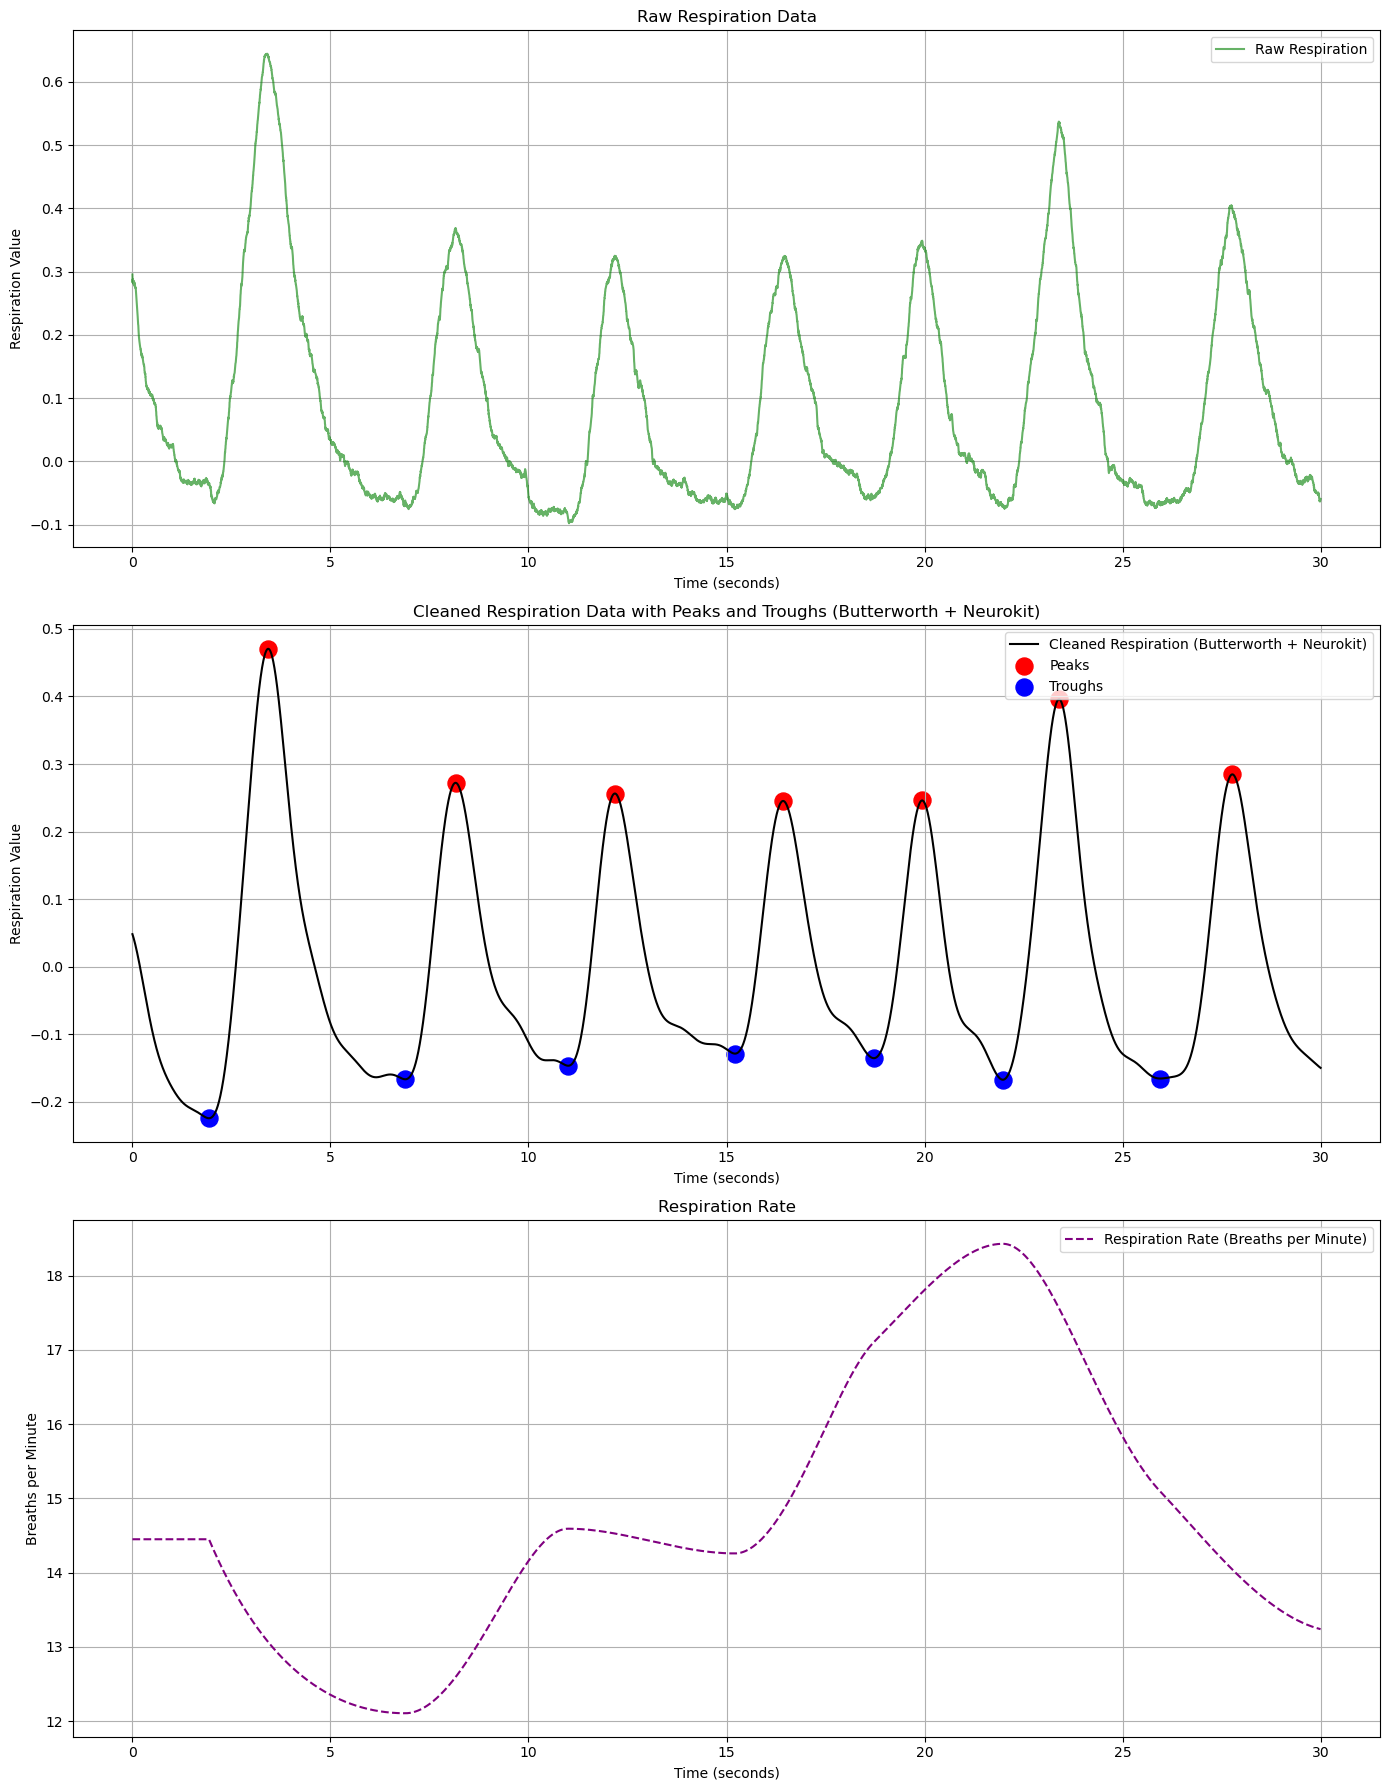

In [11]:
# Ensure the indices for slicing are within the bounds of the DataFrame
sample_rate = 250  # 250 samples per second
start_index = 1
end_index = min(7500, len(subject_df))

# Convert samples to seconds
time_in_seconds = subject_df['sample'][start_index:end_index] / sample_rate

# Respiration data for the selected range
respiration = subject_df['resp'][start_index:end_index]

# Apply a low-pass Butterworth filter to the respiration data
def low_pass_filter(data, cutoff_freq, sample_rate):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

cutoff_frequency = 1  # Set the cutoff frequency to 1 Hz
filtered_respiration = low_pass_filter(subject_df['resp'], cutoff_frequency, sample_rate)

# Clean and process the filtered respiration data using nk.rsp_process
rsp_signals, rsp_info = nk.rsp_process(filtered_respiration, sampling_rate=sample_rate, method='khodadad2018')

# Extract the cleaned respiration signal, peaks, troughs, and respiration rate
cleaned_respiration = rsp_signals["RSP_Clean"].iloc[start_index:end_index]
peaks = rsp_signals["RSP_Peaks"].iloc[start_index:end_index].values
troughs = rsp_signals["RSP_Troughs"].iloc[start_index:end_index].values
respiration_rate = rsp_signals["RSP_Rate"].iloc[start_index:end_index].values

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 18))

# Plot raw respiration data
axs[0].plot(time_in_seconds, respiration, label='Raw Respiration', color='green', alpha=0.6)
axs[0].set_title('Raw Respiration Data')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Respiration Value')
axs[0].legend()
axs[0].grid(True)

# Plot cleaned respiration data with peaks and troughs
axs[1].plot(time_in_seconds, cleaned_respiration, label='Cleaned Respiration (Butterworth + Neurokit)', color='black')
axs[1].scatter(time_in_seconds[peaks == 1], cleaned_respiration[peaks == 1], color='red', marker='o', s=150, label='Peaks')
axs[1].scatter(time_in_seconds[troughs == 1], cleaned_respiration[troughs == 1], color='blue', marker='o', s=150, label='Troughs')
axs[1].set_title('Cleaned Respiration Data with Peaks and Troughs (Butterworth + Neurokit)')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Respiration Value')
axs[1].legend()
axs[1].grid(True)

# Plot respiration rate
axs[2].plot(time_in_seconds, respiration_rate, label='Respiration Rate (Breaths per Minute)', color='purple', linestyle='--')
axs[2].set_title('Respiration Rate')
axs[2].set_xlabel('Time (seconds)')
axs[2].set_ylabel('Breaths per Minute')
axs[2].legend()
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


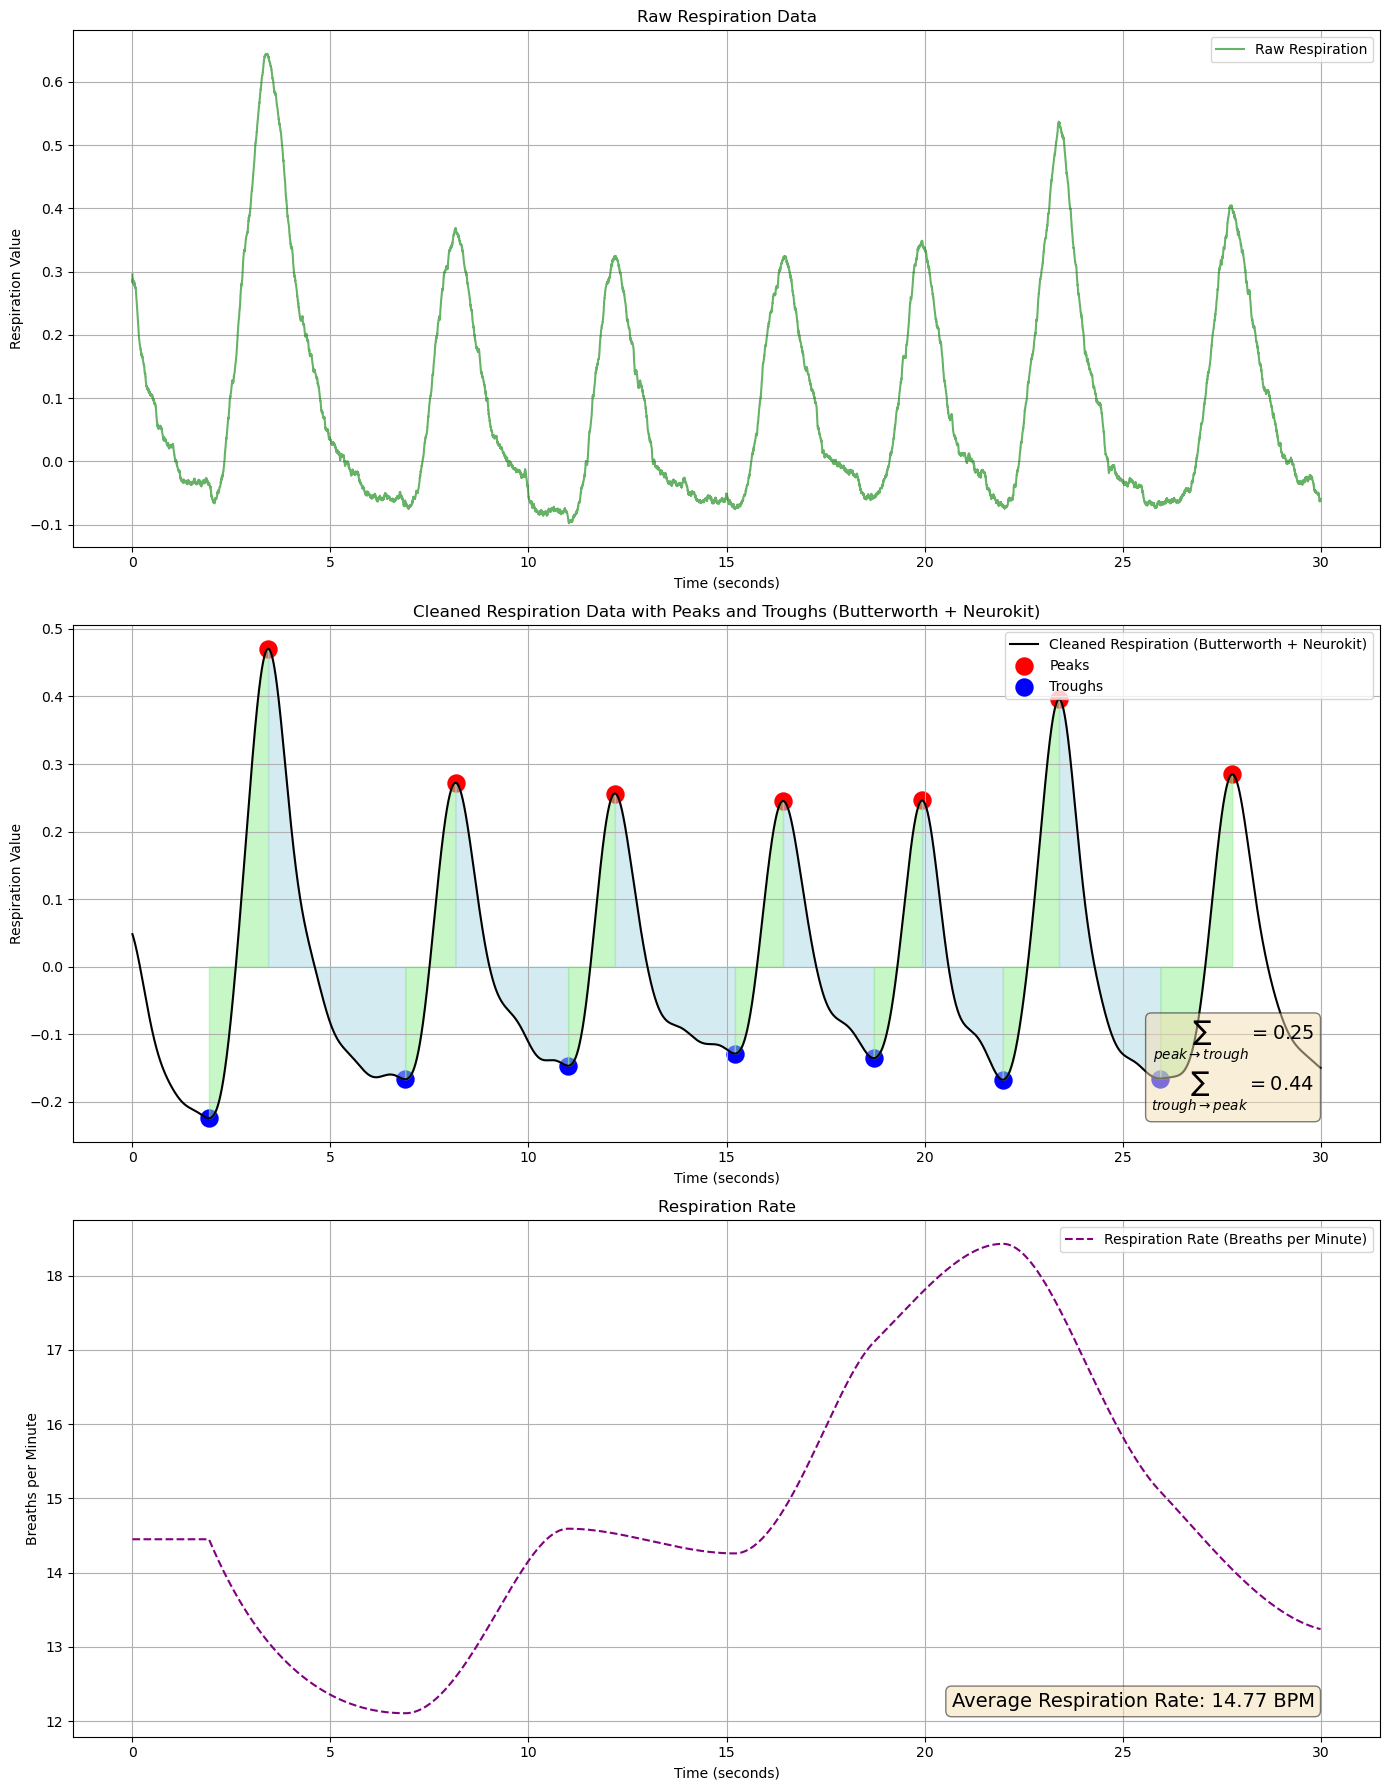

Shaded Areas from Peak to Next Trough: [-0.0275835313031218, -0.06877921592066386, -0.08968710408738607, -0.0067843210969271844, -0.04571724353389725, -0.01094343535844522]
Shaded Areas from Trough to Next Peak: [0.12323244601202704, 0.039823044747921046, 0.04139428028045737, 0.04984808362360308, 0.03768956260192258, 0.11123362463095748, -0.03195949305541389]


In [12]:
# Ensure the indices for slicing are within the bounds of the DataFrame
sample_rate = 250  # 250 samples per second
start_index = 1
end_index = min(7500, len(subject_df))

# Convert samples to seconds
time_in_seconds = subject_df['sample'].iloc[start_index:end_index] / sample_rate

# Respiration data for the selected range
respiration = subject_df['resp'].iloc[start_index:end_index]

# Apply a low-pass Butterworth filter to the respiration data
def low_pass_filter(data, cutoff_freq, sample_rate):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

cutoff_frequency = 1  # Set the cutoff frequency to 1 Hz
filtered_respiration = low_pass_filter(subject_df['resp'], cutoff_frequency, sample_rate)

# Clean and process the filtered respiration data using nk.rsp_process
rsp_signals, rsp_info = nk.rsp_process(filtered_respiration, sampling_rate=sample_rate, method='khodadad2018')

# Extract the cleaned respiration signal, peaks, troughs, and respiration rate
cleaned_respiration = rsp_signals["RSP_Clean"][start_index:end_index]
peaks = rsp_signals["RSP_Peaks"][start_index:end_index].values
troughs = rsp_signals["RSP_Troughs"][start_index:end_index].values
respiration_rate = rsp_signals["RSP_Rate"][start_index:end_index].values

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 18))

# Plot raw respiration data
axs[0].plot(time_in_seconds, respiration, label='Raw Respiration', color='green', alpha=0.6)
axs[0].set_title('Raw Respiration Data')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Respiration Value')
axs[0].legend()
axs[0].grid(True)

# Plot cleaned respiration data with peaks and troughs
axs[1].plot(time_in_seconds, cleaned_respiration, label='Cleaned Respiration (Butterworth + Neurokit)', color='black')
axs[1].scatter(time_in_seconds[peaks == 1], cleaned_respiration[peaks == 1], color='red', marker='o', s=150, label='Peaks')
axs[1].scatter(time_in_seconds[troughs == 1], cleaned_respiration[troughs == 1], color='blue', marker='o', s=150, label='Troughs')

# Calculate and shade tidal volumes
shaded_areas_peak_to_trough = []
shaded_areas_trough_to_peak = []

for i in range(1, len(peaks)):
    if peaks[i] == 1 and i < len(troughs) - 1 and troughs[i] == 0:
        # Shade area from peak to next trough
        next_trough_idx = np.where(troughs[i:] == 1)[0]
        if next_trough_idx.size > 0:
            next_trough_idx = next_trough_idx[0] + i
            axs[1].fill_between(time_in_seconds[i:next_trough_idx], 0, cleaned_respiration[i:next_trough_idx], color='lightblue', alpha=0.5)
            area = np.trapz(cleaned_respiration[i:next_trough_idx], time_in_seconds[i:next_trough_idx])
            shaded_areas_peak_to_trough.append(area)
    elif troughs[i] == 1 and i < len(peaks) - 1 and peaks[i] == 0:
        # Shade area from trough to next peak
        next_peak_idx = np.where(peaks[i:] == 1)[0]
        if next_peak_idx.size > 0:
            next_peak_idx = next_peak_idx[0] + i
            axs[1].fill_between(time_in_seconds[i:next_peak_idx], 0, cleaned_respiration[i:next_peak_idx], color='lightgreen', alpha=0.5)
            area = np.trapz(cleaned_respiration[i:next_peak_idx], time_in_seconds[i:next_peak_idx])
            shaded_areas_trough_to_peak.append(area)

# Sum the absolute values of shaded areas
sum_peak_to_trough = np.sum(np.abs(shaded_areas_peak_to_trough))
sum_trough_to_peak = np.sum(np.abs(shaded_areas_trough_to_peak))

# Display the sums as text in the second subplot
textstr = '\n'.join((
    r'$\sum_{peak \rightarrow trough}=%.2f$' % (sum_peak_to_trough,),
    r'$\sum_{trough \rightarrow peak}=%.2f$' % (sum_trough_to_peak,)
))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[1].text(0.95, 0.05, textstr, transform=axs[1].transAxes, fontsize=14,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

axs[1].set_title('Cleaned Respiration Data with Peaks and Troughs (Butterworth + Neurokit)')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Respiration Value')
axs[1].legend()
axs[1].grid(True)

# Calculate and annotate the average respiration rate
average_respiration_rate = np.mean(respiration_rate)
textstr_rate = f'Average Respiration Rate: {average_respiration_rate:.2f} BPM'
props_rate = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[2].text(0.95, 0.05, textstr_rate, transform=axs[2].transAxes, fontsize=14,
            verticalalignment='bottom', horizontalalignment='right', bbox=props_rate)

# Plot respiration rate
axs[2].plot(time_in_seconds, respiration_rate, label='Respiration Rate (Breaths per Minute)', color='purple', linestyle='--')
axs[2].set_title('Respiration Rate')
axs[2].set_xlabel('Time (seconds)')
axs[2].set_ylabel('Breaths per Minute')
axs[2].legend()
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Print the shaded areas
print("Shaded Areas from Peak to Next Trough:", shaded_areas_peak_to_trough)
print("Shaded Areas from Trough to Next Peak:", shaded_areas_trough_to_peak)



In [13]:
def calculate_respiration_metrics(respiration_data, sample_rate=250, cutoff_frequency=1):
    """
    Calculate respiration metrics including mean respiration rate, areas from peak to trough, and trough to peak.
    
    Args:
    - respiration_data (array-like): The respiration signal data.
    - sample_rate (int): The sampling rate of the data.
    - cutoff_frequency (int): The cutoff frequency for the low-pass filter.
    
    Returns:
    - dict: A dictionary containing mean respiration rate, areas from peak to trough, and trough to peak.
    """
    
    # Apply low-pass Butterworth filter
    def low_pass_filter(data, cutoff_freq, sample_rate):
        nyquist = 0.5 * sample_rate
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(4, normal_cutoff, btype='low', analog=False)
        filtered_data = filtfilt(b, a, data)
        return filtered_data

    filtered_respiration = low_pass_filter(respiration_data, cutoff_frequency, sample_rate)

    # Clean and process the filtered respiration data
    rsp_signals, rsp_info = nk.rsp_process(filtered_respiration, sampling_rate=sample_rate, method='khodadad2018')
    cleaned_respiration = rsp_signals["RSP_Clean"]
    peaks = rsp_signals["RSP_Peaks"].values
    troughs = rsp_signals["RSP_Troughs"].values
    respiration_rate = rsp_signals["RSP_Rate"].values

    # Calculate mean respiration rate
    mean_respiration_rate = np.mean(respiration_rate)
    total_peak = len(peaks[peaks == 1])
    total_trough = len(troughs[troughs == 1])

    # calculate brv
    temp = rsp_signals.reset_index()
    d_peaks_in_ms = np.diff(temp[temp['RSP_Peaks'] == 1].index.values)
    d_peaks_in_ms = d_peaks_in_ms[~np.isnan(d_peaks_in_ms)] 
    
    d_d_peaks_in_ms = np.diff(d_peaks_in_ms)
    d_d_peaks_in_ms = d_d_peaks_in_ms[~np.isnan(d_d_peaks_in_ms)] 
    breath_rate_variability = np.sqrt(np.mean(np.square(d_d_peaks_in_ms)))

    
    # Calculate the areas for peak-to-trough and trough-to-peak transitions and average latency
    shaded_areas_peak_to_trough = []
    shaded_areas_trough_to_peak = []
    
    latency_peak_to_trough = []
    latency_trough_to_peak = []
    
    for i in range(1, len(cleaned_respiration)):
        if peaks[i] == 1 and i < len(troughs) - 1:
            # Find the next trough index after this peak
            next_trough_idx = np.where(troughs[i:] == 1)[0]
            if next_trough_idx.size > 0:
                next_trough_idx = next_trough_idx[0] + i
                area = np.trapz(cleaned_respiration.iloc[i:next_trough_idx], dx=1/sample_rate)
                shaded_areas_peak_to_trough.append(area)
                
                latency = (next_trough_idx - i) / sample_rate
                latency_peak_to_trough.append(latency)

                
        elif troughs[i] == 1 and i < len(peaks) - 1:
            # Find the next peak index after this trough
            next_peak_idx = np.where(peaks[i:] == 1)[0]
            if next_peak_idx.size > 0:
                next_peak_idx = next_peak_idx[0] + i
                area = np.trapz(cleaned_respiration.iloc[i:next_peak_idx], dx=1/sample_rate)
                shaded_areas_trough_to_peak.append(area)
                
                latency = (next_peak_idx - i) / sample_rate
                latency_trough_to_peak.append(latency)

                
    sum_peak_to_trough = np.sum(np.abs(shaded_areas_peak_to_trough))
    sum_trough_to_peak = np.sum(np.abs(shaded_areas_trough_to_peak))
    average_latency_peak_to_trough = np.mean(latency_peak_to_trough)
    average_latency_trough_to_peak = np.mean(latency_trough_to_peak)
    # Return the calculated metrics
    return {
        "Mean Respiration Rate": mean_respiration_rate,
        "Total Area Peak to Trough": sum_peak_to_trough,
        "Total Area Trough to Peak": sum_trough_to_peak,
        "Average time Peak to Trough": average_latency_peak_to_trough,
        "Average time Trough to Peak": average_latency_trough_to_peak,
        "Total_peaks": total_peak,
        "Total_trough": total_trough,
        "Breath_rate_variability" : breath_rate_variability,
    }


In [14]:
def get_ecg_features(ecg, time_in_sec, fs):
    """
    Compute ECG features from raw ECG signal.

    Parameters
    ----------
    ecg : array-like
        Raw ECG signal.
    time_in_sec : array-like
        Timestamps corresponding to each sample of the ECG signal.
    fs : float
        Sampling frequency of the ECG signal.

    Returns
    -------
    array
        Array of ECG features: [mean heart rate, maximum heart rate, minimum heart rate, heart rate variability].
    """
    try:
        b, a = butter(4, (0.25, 25), 'bandpass', fs=fs)
        ecg_filt = filtfilt(b, a, ecg, axis=0)
        ecg_cleaned = nk.ecg_clean(ecg_filt, sampling_rate=fs)
        instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs,method="engzeemod2012")
    except Exception as e:
        raise ValueError("Error processing ECG signal: " + str(e))

    rr_times = time_in_sec[rpeaks['ECG_R_Peaks']]
    if len(rr_times) == 0:
        raise ValueError("No R-peaks detected in ECG signal.")
    
    # Assuming d_rr contains the time intervals between successive heartbeats in seconds
    d_rr = np.diff(rr_times)
    heart_rate = 60 / d_rr
    if heart_rate.size == 0:
        raise ValueError("Error computing heart rate from ECG signal.")
    
    valid_heart_rate = heart_rate[~np.isnan(heart_rate)]
    z_scores = np.abs(stats.zscore(valid_heart_rate))

    # Define a z-score threshold beyond which a value is considered an outlier
    z_score_threshold = 4.0

    # Remove outliers from the valid_heart_rate array
    heart_rate = valid_heart_rate[z_scores <= z_score_threshold]

    hr_mean = np.nanmean(heart_rate)
    hr_min = np.nanmin(heart_rate)
    hr_max = np.nanmax(heart_rate)
    d_rr_ms = 1000 * d_rr
    d_d_rr_ms = np.diff(d_rr_ms)

    valid_d_d_rr_ms = d_d_rr_ms[~np.isnan(d_d_rr_ms)] 
    z_scores = np.abs(stats.zscore(valid_d_d_rr_ms))
    d_d_rr_ms= valid_d_d_rr_ms[z_scores <= z_score_threshold]
    heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))

    # Create a new signal 'ecg_with_rr_intervals' with RR intervals and a 1-second window around each RR interval
    ecg_with_rr_intervals = []
    ecg_with_rr_intervals_cleaned = []

    for rr_interval in rr_times:
        start_time = rr_interval - 0.1 # 1 second before the RR interval
        end_time = rr_interval + 0.1   # 1 second after the RR interval
        indices = np.where((time_in_sec >= start_time) & (time_in_sec <= end_time))[0]

        # Validate indices to ensure they are within bounds
        indices = indices[(indices >= 0) & (indices < len(ecg))]

        if len(indices) > 0:
            ecg_with_rr_intervals.extend(ecg[indices])
            ecg_with_rr_intervals_cleaned.extend(ecg_cleaned[indices])

    # Convert lists to NumPy arrays
    ecg_with_rr_intervals = np.array(ecg_with_rr_intervals)
    ecg_with_rr_intervals_cleaned = np.array(ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    signal_power = np.var(ecg_with_rr_intervals)
    noise_power = np.var(ecg_with_rr_intervals - ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    #signal_power = np.var(ecg)
    #noise_power = np.var(ecg - ecg_cleaned)

     # Calculate SNR in dB and append it to the array
    snr_values = 10 * np.log10(signal_power / noise_power)
    
    return hr_mean, hr_max, hr_min, heart_rate_variability, snr_values

In [15]:
calculate_respiration_metrics(subject_df['resp'].iloc[start_index:end_index],sample_rate=250, cutoff_frequency=1)

{'Mean Respiration Rate': 15.622901954070029,
 'Total Area Peak to Trough': 0.30913062665294605,
 'Total Area Trough to Peak': 0.3306151184888064,
 'Average time Peak to Trough': 2.7359999999999998,
 'Average time Trough to Peak': 1.298,
 'Total_peaks': 6,
 'Total_trough': 6,
 'Breath_rate_variability': 131.28880378768022}

In [16]:
SAMPLE_RATE = 250
length = len(subject_df['ecg'].iloc[start_index:end_index])
hr_mean, hr_max, hr_min, heart_rate_variability, snr_values = get_ecg_features(subject_df['ecg'].iloc[start_index:end_index].reset_index(drop=True), np.arange(0,length/SAMPLE_RATE,1/SAMPLE_RATE), fs=SAMPLE_RATE)
print(f"{hr_mean},  {hr_max},  {hr_min}, {heart_rate_variability}, {snr_values}")

58.42193555618593,  66.96428571428572,  51.19453924914673, 72.52483610358522, 10.625128583784662


In [17]:
type(subject_df['resp'].iloc[start_index:end_index])

pandas.core.series.Series

# Modelling

In [18]:
CHUCK_SIZE = 30 * 250 #60 second * 250 Hz

In [19]:
df

,ecg,resp,subject_id,sample,sample_rate
0,7.952000,8.000000,f1y01,0,250
1,7.936000,8.044000,f1y01,1,250
2,8.004000,8.000000,f1y01,2,250
3,8.064000,8.052000,f1y01,3,250
4,7.980000,8.012000,f1y01,4,250
...,...,...,...,...,...
71212457,-0.059550,0.136491,f2y02,1758649,250
71212458,-0.064602,0.141801,f2y02,1758650,250
71212459,-0.057322,0.136319,f2y02,1758651,250
71212460,-0.051296,0.143035,f2y02,1758652,250


In [20]:
df['sample_rate'].unique()

array([250])

In [21]:
import pandas as pd

# Function to split the data into chunks of a specified size
def split_into_chunks(group, chunk_size=CHUCK_SIZE):
    num_chunks = len(group) // chunk_size  # Calculate how many full chunks we can have
    chunks = []
    for i in range(num_chunks):
        start = i * chunk_size
        end = start + chunk_size
        chunks.append({
            'ecg': group['ecg'].iloc[start:end].tolist(),
            'resp': group['resp'].iloc[start:end].tolist()
        })
    return chunks

# Group the DataFrame by 'subject_id'
grouped = df.groupby('subject_id')

# Dictionary to hold the chunks for each subject
subject_chunks = {}

# Loop through each group, split into chunks, and store in the dictionary
for subject_id, group in grouped:
    subject_chunks[subject_id] = split_into_chunks(group)

# Flatten the dictionary into a DataFrame
# Initialize an empty list to hold all chunk records
chunk_data = []

# Iterate through each subject and their chunks
for subject_id, chunks in subject_chunks.items():
    for index, chunk in enumerate(chunks):
        chunk_data.append({
            'subject_id': subject_id,
            'chunk_id': index,
            'ecg': chunk['ecg'],
            'resp': chunk['resp']
        })

# Convert the list of dictionaries to a DataFrame
chunks_df = pd.DataFrame(chunk_data)

# Print the DataFrame structure
print(chunks_df.head())

  subject_id  chunk_id                                                ecg  \
0      f1o01         0  [8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...   
1      f1o01         1  [8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...   
2      f1o01         2  [8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...   
3      f1o01         3  [8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...   
4      f1o01         4  [8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...   

                                                resp  
0  [8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4...  
1  [8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07...  
2  [8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6...  
3  [8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6...  
4  [8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5...  


In [22]:
chunks_df

,subject_id,chunk_id,ecg,resp
0,f1o01,0,"[8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...","[8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4..."
1,f1o01,1,"[8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...","[8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07..."
2,f1o01,2,"[8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...","[8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6..."
3,f1o01,3,"[8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...","[8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6..."
4,f1o01,4,"[8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...","[8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5..."
...,...,...,...,...
9471,f2y10,234,"[-0.01708984375, -0.01220703125, -0.01953125, ...","[0.54443359375, 0.5419921875, 0.5517578125, 0...."
9472,f2y10,235,"[-0.1220703125, -0.23681640625, -0.25390625, -...","[-0.17333984375, -0.1708984375, -0.17333984375..."
9473,f2y10,236,"[0.1025390625, 0.07568359375, 0.0439453125, 0....","[-0.185546875, -0.185546875, -0.1806640625, -0..."
9474,f2y10,237,"[-0.1123046875, -0.107421875, -0.10986328125, ...","[0.0830078125, 0.087890625, 0.0927734375, 0.09..."


In [23]:
len(chunks_df)

9476

In [24]:
chunks_df = chunks_df[chunks_df['resp'].apply(len) == CHUCK_SIZE]
chunks_df = chunks_df[chunks_df['ecg'].apply(len) == CHUCK_SIZE]

In [25]:
len(chunks_df )

9476

In [26]:
chunks_df.head()

,subject_id,chunk_id,ecg,resp
0,f1o01,0,"[8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...","[8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4..."
1,f1o01,1,"[8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...","[8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07..."
2,f1o01,2,"[8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...","[8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6..."
3,f1o01,3,"[8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...","[8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6..."
4,f1o01,4,"[8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...","[8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5..."


In [27]:
SAMPLE_RATE = 250
CUT_OFF_SNR = 5

snr_list = []
# Pre-define new columns for calculated metrics
chunks_df['Mean_Respiration_Rate'] = np.nan
chunks_df['Total_Area_Peak_to_Trough'] = np.nan
chunks_df['Total_Area_Trough_to_Peak'] = np.nan
chunks_df['Mean_latency_Trough_to_Peak'] = np.nan
chunks_df['Mean_latency_Peak_to_Trough'] = np.nan
chunks_df['hr_min'] = np.nan
chunks_df['hr_mean'] = np.nan
chunks_df['hr_max'] = np.nan
chunks_df['hrv'] = np.nan
chunks_df['snr'] = np.nan
chunks_df['Total_peaks'] = np.nan
chunks_df['Total_trough'] = np.nan
chunks_df['Breath_rate_variability'] = np.nan

# List to track indices of rows that cause errors
error_indices = []

for idx, row in chunks_df.iterrows():
    print(idx)
        
    try:
        hr_mean, hr_max, hr_min, heart_rate_variability, snr_values = get_ecg_features(pd.Series(row['ecg']), np.arange(0,len(row['ecg'])/SAMPLE_RATE,1/SAMPLE_RATE), fs=SAMPLE_RATE)
        snr_list.append(snr_values)
        # if snr_values < CUT_OFF_SNR:
        #     continue
            
        # Try to calculate respiration metrics for the current row
        results = calculate_respiration_metrics(row['resp'])
        chunks_df.at[idx, 'Mean_Respiration_Rate'] = results['Mean Respiration Rate']
        chunks_df.at[idx, 'Total_Area_Trough_to_Peak'] = results['Total Area Trough to Peak']
        chunks_df.at[idx, 'Total_Area_Peak_to_Trough'] = results['Total Area Peak to Trough']
        chunks_df.at[idx, 'Mean_latency_Trough_to_Peak'] = results['Average time Trough to Peak']
        chunks_df.at[idx, 'Mean_latency_Peak_to_Trough'] = results['Average time Peak to Trough']
        chunks_df.at[idx, 'hr_min'] = hr_min
        chunks_df.at[idx, 'hr_mean'] = hr_mean
        chunks_df.at[idx, 'hr_max'] = hr_max
        chunks_df.at[idx, 'hrv'] = heart_rate_variability
        chunks_df.at[idx, 'snr'] = snr_values
        chunks_df.at[idx, 'Total_peaks'] = results['Total_peaks']
        chunks_df.at[idx, 'Total_trough'] = results['Total_trough']
        chunks_df.at[idx, 'Breath_rate_variability'] = results['Breath_rate_variability']
        
    except Exception as e:
        # Log error and mark index for potential removal
        print(f"Error processing row {idx}: {e}")
        error_indices.append(idx)

# Optionally, drop rows that caused errors from the DataFrame
chunks_df = chunks_df.drop(index=error_indices)

# Print updated DataFrame structure or save it to a file
print(chunks_df.head())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


34
35


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


63
64
65
66
67
68
69
70


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


97
98
99
100
101


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


102
103


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


104
105
106
107
108


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


109
110
111
112
113
114
115
116
117
118
119
120
121
122
123


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


124
125


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


126
127


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


128
129
130
131
132
133
134
135
136
137
138
139


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


140
141
142
143
144
145


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


146
147
148
149
150


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


195
196


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


197
198
199
200
201
202
203
204
205
206
207
208


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


235
236
237
238
239
240


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


241
242
243
244
245
246


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


247
248
249
250


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


357
358
359
360
361
362
363
364
365


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


366
367
368


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


369
370
371
372
373
374
375
376


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


377
378
379
380
381
382
383
384
385
386
387


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


442
443
444
445
446
447
448
449
450
451
452
453
454
455


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


456
457
458
459
460
461
462
463
464


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


697
698
699
700
701
702
703
704
705
706
707
708
709
710


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


711
712
713
714


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


715
716


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


717
718
719
720
721
722
723


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


724
725
726
727
728
729
730
731
732
733


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


734
735
736
737
738
739
740
741
742
743
744
745
746


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


747
748


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


749
750
751
752
753
754


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


755
756


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


757
758
759


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


760
761


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


762
763
764
765
766
767
768
769
770
771
772


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


773
774
775
776
777
778
779
780
781


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


782
783
784


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


785
786
787
788
789


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


790
791
792
793
794
795


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


796
797
798
799
800
801
802
803
804
805
806


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


807
808
809


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


826
827
828
829
830
831
Error processing row 831: Error computing heart rate from ECG signal.
832
833
834
835
836
837
838


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


868
869
870
871
872
873


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


874
875
876


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


877
878
879
880
881
882
883
884
885
886
887
888


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


889
890
891


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


922
923
924
925
926
927
928
929


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


930
931
932
933
934


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


935
936
937
938
939


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


940
941
942


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


943
944
945
946


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


947
948


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


949
950


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


951
952
953
954
955
956
957
958
959
960
961


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


962
963
964


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


965
966
967
968
969


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


970
971
972


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


973
974
975
976
977


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


978
979


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


980
981


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


982
983
984


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


985
986


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

987
988


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


989
990


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


991
992
993


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute sy

994
995


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


996
997


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


998
999
1000
1001


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1002
1003


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1004
1005


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1006
1007


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1008
1009
1010


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1011
1012
1013
1014
1015
1016


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1017
1018


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1019
1020
1021


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1022
1023


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1024
1025


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

1026
1027


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1028
1029


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1030
1031
1032
1033


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1034
1035
1036


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empt

1037
1038
1039
1040


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

1041
1042


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1043
1044


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/t

1045
1046
1047
1048
1049


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

1050
1051


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

1052
1053


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

1054
1055


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1056
1057


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1058
1059


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1060
1061


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1062
1063


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1064
1065


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1066
1067
1068


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1069
1070
1071
1072


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1073
1074


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/t

1075
1076
1077


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1078
1079


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1080
1081


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1082
1083


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

1084
1085
1086
1087


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1088
1089


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1090
1091


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1092
1093
1094
1095


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

1096
1097


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1098
1099


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1100
1101
1102


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1103
1104
1105
1106


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

1107
1108


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1109
1110


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1111
1112


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1113
1114


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1115
1116


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

1117
1118


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1119
1120
1121
1122


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

1123
1124


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

1125
1126


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

1127
1128
1129


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1130
1131


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1132
1133


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1134
1135
1136


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1137
1138


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1139
1140


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1141
1142


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

1143
1144


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

1145
1146


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1147
1148


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1149
1150


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1151
1152


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1153
1154
1155


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1156
1157


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1158
1159


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

1160
1161


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

1162
1163
1164
1165


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

1166
1167


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1168
1169
1170


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for 

1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1392
1393
1394
1395
1396
1397


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1425
1426
1427
1428
1429
1430


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1431
1432
1433
1434
1435
1436
1437


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1438
1439
1440
1441
1442
1443
1444
1445
1446


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1447
1448
1449
1450
1451
1452


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1453
1454
1455
1456
1457
1458
1459
1460


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1461
1462
1463
1464
1465
1466
1467
1468


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1469
1470
1471


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1472
1473
1474
1475
1476
1477
1478
1479


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1480
1481
1482
1483
1484


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1485
1486
1487
1488
1489


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1490
1491
1492
1493
1494
1495


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1496
1497
1498
1499
1500
1501
1502
1503


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1504
1505
1506
1507
1508


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1509
1510


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1511
1512


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1513
1514
1515


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1516
1517
1518


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1554
1555
1556
1557
1558
1559


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1560
1561
1562
1563
1564
1565


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1566
1567
1568
1569
1570


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1571
1572


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

1573
1574
1575
1576


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1577
1578
1579
1580
1581
1582
1583
1584


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

1632
1633


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1634
1635
1636
1637
1638


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1639
1640
1641
1642
1643
1644
1645
1646
1647


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1648
1649
1650
1651
1652
1653
1654


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1655
1656
1657
Error processing row 1657: Error computing heart rate from ECG signal.
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794


/tmp/ipykernel_68577/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1895
1896
1897
1898
1899
1900


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1901
1902
1903
1904
1905
1906


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1907
1908
1909


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1945
1946
1947


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1948
1949
1950
1951
1952
1953


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1954
1955
1956


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1957
1958
1959
1960


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1961
1962


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1963
1964
1965
1966
1967
1968


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute sy

1969
1970
1971
1972
1973


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1974
1975
1976


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1977
1978
1979
1980
1981


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1982
1983
1984


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1985
1986
1987
1988


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

1989
1990
1991


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1992
1993
1994
1995
1996
1997


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

1998
1999
2000
2001
2002


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2003
2004
2005
2006


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2007
2008
2009


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2010
2011


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2012
2013
2014


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2015
2016
2017
2018
2019
2020


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2021
2022


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2023
2024


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2025
2026
2027


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2028
2029


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2030
2031
2032
2033
2034


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2035
2036
2037
2038
2039
2040


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2041
2042


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2043
2044
2045
2046
2047
2048
2049
2050


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2051
2052
2053


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2054
2055
2056


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2057
2058


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2059
2060
2061


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2062
2063
2064
2065
2066


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2067
2068


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2069
2070
2071
2072
2073


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2074
2075


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2076
2077
2078
2079
2080


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2081
2082
2083
2084
2085


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2086
2087
2088
2089
2090


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2091
2092


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2093
2094
2095
2096
2097


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2098
2099
2100
2101
2102
2103
2104
2105


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2106
2107
2108
2109
2110


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2111
2112
2113
2114
2115


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2116
2117
2118


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2119
2120
2121
2122


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2123
2124
2125
2126
2127
2128


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2129
2130
2131
2132
2133
2134


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for 

2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2159
2160


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2184
2185
2186
2187
2188


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2189
2190
2191
2192
2193
2194


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2195
2196
2197
2198
2199
2200
2201
2202
2203


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2215
2216
2217


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2236
2237
2238
2239
2240
2241
2242
2243
2244


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
Error processing row 2264: index -1 is out of bounds for axis 0 with size 0
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2343
2344
2345


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2346
2347
2348
2349
2350
2351
2352
2353


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2399
2400
2401
2402
2403
2404


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2405
2406
2407
2408


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2582
2583
2584
2585
2586
2587


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2612
2613
2614
2615
2616
2617
2618
2619


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2620
2621
2622


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2623
2624
2625
2626
2627


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2628
2629
2630
2631
2632
2633


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2645
2646
2647
2648
2649
2650
2651
2652
2653


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2665
2666
2667
2668
2669
2670


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2671
2672
2673
2674
2675
2676


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2692
2693
2694
2695
2696
2697


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2698
2699


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2700
2701


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2702
2703
2704
2705
2706
2707
2708
2709


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2710
2711
2712
2713
2714


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2715
2716
2717
2718
2719
2720
2721
2722
2723


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2724
2725


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2726
2727
2728
2729
2730
2731


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2732
2733
2734
2735
2736
2737
2738
2739


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2740
2741


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2742
2743


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2744
2745
2746
2747
2748
2749
2750
2751
2752
2753


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2754
2755
2756
2757
2758
2759
2760
2761


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2762
2763
2764
2765
2766
2767
2768
2769
2770


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2786
2787
2788
2789
2790


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2791
2792
2793


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2794
2795
2796


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2797
2798
2799
2800
2801
2802


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2803
2804
2805
2806
2807
2808
2809


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2810
2811


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2812
2813
2814
2815
2816
2817
2818
2819


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2820
2821
2822


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2823
2824
2825
2826
2827
2828
2829
2830
2831


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2832
2833
2834
2835


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2847
2848


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2849
2850
2851
2852
2853
2854
2855
2856
2857
2858


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

2859
2860


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2861
2862


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2863
2864


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2865
2866


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2867
2868
2869


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

2870
2871


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

2872
2873


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

2874
2875


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

2876
2877


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2878
2879


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

2880
2881


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2882
2883
2884
2885


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

2886
2887


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

2888
2889
2890


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2891
2892


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2893
2894


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2895
2896


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2897
2898
2899


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/t

2900
2901


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2902
2903


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2904
2905


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2906
2907


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2908
2909


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2910
2911


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2912
2913
2914


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2915
2916


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2917
2918


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/t

2919
2920
2921
2922
2923
2924


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

2925
2926
2927


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to comput

2928
2929
2930
2931
2932


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2933
2934


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2935
2936


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2937
2938
2939


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2940
2941


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

2942
2943


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2944
2945


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2946
2947
2948
2949
2950


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2951
2952


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2953
2954


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2955
2956


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2957
2958
2959


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2960
2961
2962


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2963
2964
2965


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2966
2967
2968


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for 

2969
2970


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2971
2972


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2973
2974


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2975
2976


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2977
2978
2979


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qd

2980
2981
2982


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2983
2984


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2985
2986


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for 

2987
2988
2989


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

2990
2991
2992
2993


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2994
2995


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2996
2997


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


2998
2999


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3000
3001


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3002
3003


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3004
3005
3006


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3007
3008


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3009
3010


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3011
3012
3013


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3014
3015


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3016
3017


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3018
3019


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3020
3021


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3022
3023
3024
3025
3026


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3027
3028


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3029
3030


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3031
3032


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3033
3034
3035


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3036
3037


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3038
3039
3040


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3041
3042
3043


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3044
3045


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3046
3047


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3048
3049
3050


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3051
3052


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3053
3054


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3055
3056


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3057
3058


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3059
3060


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3061
3062
3063
3064
3065
3066


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3067
3068


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3069
3070


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3071
3072


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3073
3074
3075


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3076
3077
3078
3079


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3080
3081
3082
3083


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3084
3085


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3086
3087
3088
3089


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3090
3091
3092
3093


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3094
3095
3096
3097
3098


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3099
3100
3101
3102
3103
3104


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3394
3395
3396
3397
3398
3399
3400
3401
3402


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3438
3439
3440
3441
3442
3443
3444
3445


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3446
3447
3448


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3449
3450
3451
3452
3453
3454


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3455
3456
3457


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3458
3459
3460
3461
3462
3463
3464
3465


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3466
3467
3468


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3469
3470
3471
3472
3473
3474
3475
3476


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3477
3478
3479


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3480
3481
3482
3483
3484
3485
3486
3487


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3516
3517
3518


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3519
3520
3521
3522


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3523
3524
3525


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3526
3527
3528
3529
3530


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3531
3532


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3533
3534
3535


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3557
3558
3559
3560
3561
3562


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3563
3564
3565
3566
3567


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3568
3569
3570


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3571
3572
3573
3574
3575


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3576
3577
3578
3579
3580


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3581
3582


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3613
3614
3615
3616
3617
3618


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3630
3631
3632
3633
3634
3635


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3636
3637
3638
3639
3640
3641
3642
3643
3644


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3645
3646
3647
3648
3649


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3650
3651
3652
3653
3654
3655


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3656
3657
3658
3659
3660
3661
3662
3663


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3664
3665
3666
3667
3668
3669
3670
3671


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3688
3689
3690
3691
3692
3693
3694
3695


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3696
3697
3698
3699
3700
3701
3702


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3703
3704
3705


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3706
3707
3708
3709
3710


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721


/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


Error processing row 3721: zero-size array to reduction operation fmin which has no identity
3722
3723
3724
3725
3726
3727
3728
3729


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3730
3731
3732
3733
3734
3735
3736
3737
3738


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3754
3755
3756
3757
3758


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3770
3771
3772
3773
3774


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3775
3776
3777
3778
3779
3780
3781
3782
3783


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3784
3785
3786
3787
3788
3789
3790
3791


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3792
3793
3794
3795
3796
3797
3798
3799


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3800
3801


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3802
3803
3804
3805


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3829
3830
3831
3832
3833
3834
3835
3836
3837
3838


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3839
3840


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3841
3842


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3843
3844
3845


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3846
3847
3848
3849
3850


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3851
3852


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3853
3854
3855


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3856
3857


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3858
3859


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3860
3861
3862


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3863
3864


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3865
3866


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3867
3868


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3869
3870
3871


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute sy

3872
3873


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3874
3875
3876
3877
3878
3879
3880
3881


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3882
3883
3884


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3885
3886


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3887
3888


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3889
3890


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3891
3892
3893


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3894
3895
3896
3897
3898
3899
3900


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3901
3902


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3903
3904


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3905
3906


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/t

3907
3908
3909


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3910
3911


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3912
3913
3914
3915


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3916
3917
3918


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qd

3919
3920
3921
3922
3923


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3924
3925
3926


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3927
3928


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3929
3930


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

3931
3932
3933


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3934
3935


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3936
3937


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3938
3939


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3940
3941


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3942
3943


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3944
3945


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3946
3947
3948
3949
3950


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3951
3952
3953


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/t

3954
3955


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3956
3957


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3958
3959


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3960
3961


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3962
3963


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

3964
3965


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3966
3967


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3968
3969
3970


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3971
3972


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/t

3973
3974
3975


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3976
3977
3978


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3979
3980
3981


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

3982
3983
3984


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3985
3986
3987


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3988
3989


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3990
3991
3992
3993
3994


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3995
3996


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


3997
3998
3999


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4000
4001
4002
4003
4004
4005
4006


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4007
4008
4009


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4010
4011


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

4012
4013


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/t

4014
4015
4016


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4017
4018


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4019
4020


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4021
4022


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4023
4024
4025


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4026
4027
4028
4029
4030


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4031
4032


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4033
4034


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4035
4036
4037


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4038
4039


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4040
4041
4042


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/t

4043
4044
4045


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4046
4047
4048


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4049
4050
4051
4052
4053


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4054
4055
4056
4057


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4058
4059
4060


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4061
4062
4063


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4064
4065
4066


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4081
4082
4083


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4084
4085
4086


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4087
4088
4089


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4090
4091


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4092
4093


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4094
4095
4096
4097
4098


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4099
4100


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4134
4135
4136
4137
4138
4139
4140


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4141
4142
4143


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4144
4145


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4146
4147
4148
4149


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4150
4151
4152


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4153
4154


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4155
4156
4157
4158
4159
4160
4161
4162


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4163
4164
4165
4166
4167
4168


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4169
4170


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4171
4172
4173
4174
4175


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4176
4177


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4178
4179
4180
4181


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4182
4183
4184
4185
4186


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4187
4188


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4189
4190
4191
4192
4193


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4194
4195
4196


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4197
4198
4199
4200
4201


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4202
4203


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/t

4204
4205
4206


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4207
4208
4209
4210
4211
4212
4213
4214


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4215
4216


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4217
4218
4219
4220
4221
4222
4223


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

4224
4225
4226
4227
4228
4229
4230
4231
4232


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4244
4245


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4246
4247


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4248
4249


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4250
4251
4252
4253
4254
4255


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4256
4257
4258


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4259
4260
4261


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4262
4263
4264
4265
4266


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4267
4268
4269
4270
4271
4272
4273


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4274
4275
4276
4277
4278
4279


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

4291
4292
4293


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4294
4295
4296


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

4297
4298
4299
4300
4301
4302
4303
4304


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4349
4350
4351
4352
4353


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

4354
4355


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4356
4357


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4358
4359


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

4360
4361


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4362
4363


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4364
4365


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4366
4367
4368
4369
4370
4371
4372
4373
4374
4375


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4390
4391
4392


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4393
4394
4395
4396
4397


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4398
4399


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

4451
4452


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4453
4454
4455
4456
4457
4458
4459
4460
4461
4462


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4463
4464
4465
4466


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4467
4468
4469
4470
4471


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4472
4473
4474
4475
4476
4477


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

4478
4479
4480


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4481
4482
4483


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/t

4484
4485
4486
4487


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4488
4489
4490


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4491
4492


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4493
4494
4495


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4496
4497
4498


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4499
4500


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

4501
4502
4503


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4504
4505


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4506
4507
4508
4509
4510
4511


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

4512
4513


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4514
4515
4516
4517
4518
4519
4520
4521
4522


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4523
4524
4525


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4526
4527
4528
4529
4530
4531


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4544
4545


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4564
4565
4566
4567
4568
4569
4570
4571
4572


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4599
4600


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4601
4602


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4603
4604
4605
4606
4607
4608
4609
4610
4611
4612


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4613
4614
4615
4616
4617


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4618
4619
4620
4621
4622
4623
4624
4625


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4626
4627
4628
4629
4630
4631


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

4632
4633
4634
4635
4636
4637


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4638
4639
4640
4641
4642


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4643
4644
4645
4646
4647
4648


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4664
4665
4666
4667
4668


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4669
4670
4671
4672
4673


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4674
4675
4676
4677
4678
4679
4680
4681


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4682
4683
4684


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4685
4686


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4687
4688
4689


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4690
4691
4692
4693
4694


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4723
4724
4725
4726
4727
4728


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4745
4746
4747


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4748
4749


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4750
4751


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4752
4753
4754
4755
4756


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4768
4769
4770
4771
4772
4773


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4774
4775
4776
4777
4778
4779


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4780
4781
4782
4783
4784
4785
4786
4787
4788


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4789
4790


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4791
4792
4793
4794
4795
4796
4797


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4798
4799
4800


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4801
4802


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4803
4804


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4805
4806


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4807
4808
4809


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4810
4811


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4812
4813


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4814
4815


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4816
4817
4818
4819
4820


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4821
4822
4823
4824
4825
4826
4827
4828
4829


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4830
4831


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4832
4833
4834


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4835
4836
4837


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
4848


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4849
4850
4851
4852
4853


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4854
4855


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4856
4857
4858
4859
4860
4861
4862


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4863
4864
4865
4866
4867
4868


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4869
4870
4871
4872
4873
4874


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4875
4876
4877
4878
4879


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4880
4881


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4882
4883
4884
4885
4886
4887


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4888
4889


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4890
4891
4892
4893
4894
4895


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4896
4897


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4898
4899


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4900
4901
4902
4903
4904


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4905
4906


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4907
4908
4909
4910
4911
4912


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4913
4914


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4915
4916
4917
4918
4919
4920


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4921
4922
4923
4924
4925


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4926
4927
4928
4929
4930
4931


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4932
4933
4934
4935
4936
4937


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4938
4939


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4940
4941
4942
4943
4944
4945


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4946
4947


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4948
4949


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4950
4951
4952


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4953
4954
4955
4956


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4957
4958


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4959
4960


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4961
4962
4963


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4964
4965


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4966
4967
4968
4969
4970
4971
4972


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4973
4974


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4975
4976
4977
4978
4979
4980


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4981
4982
4983
4984
4985
4986
4987
4988


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4989
4990


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4991
4992
4993
4994
4995


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4996
4997


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


4998
4999


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5000
5001
5002
5003
5004


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5005
5006
5007


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5008
5009
5010


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5011
5012


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5013
5014


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5015
5016
5017


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5018
5019


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


5020
5021
Error processing row 5021: Error processing ECG signal: 0
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5047
5048
5049
5050
5051
5052


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5079
5080
5081


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5150
5151
5152
5153
5154
5155
5156
5157
5158


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5449
5450
5451


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5452
5453
5454


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5455
5456


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5457
5458
5459
5460
5461
5462
5463
5464


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5465
5466
5467
5468
5469
5470
5471
5472


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5473
5474
5475


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5476
5477


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5478
5479
5480


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5493
5494
5495
5496
5497
5498
5499
5500


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5515
5516
5517
5518


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5531
5532


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5533
5534
5535
5536
5537


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5538
5539
5540
5541
5542


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5543
5544


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5545
5546


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5547
5548
5549


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5550
5551
5552
5553
5554


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5569
5570
5571


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5572
5573
5574
5575
5576
5577
5578
5579


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5580
5581
5582


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5583
5584


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5585
5586
5587
5588
5589
5590
5591
5592


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5593
5594
5595
5596
5597


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5622
5623


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5636
5637


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5638
5639


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5660
5661
5662
5663
5664


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5665
5666


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5667
5668


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5669
5670


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5671
5672
5673
5674
5675
5676
5677
5678


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5679
5680


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5681
5682


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5683
5684
5685
5686
5687


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5688
5689
5690
5691
5692
5693
5694
5695
5696


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/t

5697
5698


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5699
5700


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5701
5702
5703


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5704
5705


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5706
5707
5708
5709
5710
5711
5712
5713
5714


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5715
5716


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5717
5718
5719
5720
5721


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5722
Error processing row 5722: No R-peaks detected in ECG signal.
5723
Error processing row 5723: Error computing heart rate from ECG signal.
5724
Error processing row 5724: No R-peaks detected in ECG signal.
5725
Error processing row 5725: Error computing heart rate from ECG signal.
5726
Error processing row 5726: No R-peaks detected in ECG signal.
5727
Error processing row 5727: No R-peaks detected in ECG signal.
5728
Error processing row 5728: No R-peaks detected in ECG signal.
5729
Error processing row 5729: Error computing heart rate from ECG signal.
5730
Error processing row 5730: Error computing heart rate from ECG signal.
5731
5732
Error processing row 5732: Error processing ECG signal: pop from empty list
5733
Error processing row 5733: No R-peaks detected in ECG signal.
5734
Error processing row 5734: No R-peaks detected in ECG signal.
5735
Error processing row 5735: Error computing heart rate from ECG signal.
5736
Error processing row 5736: Error computing heart rate from E

/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


Error processing row 5798: zero-size array to reduction operation fmin which has no identity
5799
Error processing row 5799: zero-size array to reduction operation fmin which has no identity
5800
Error processing row 5800: No R-peaks detected in ECG signal.
5801
Error processing row 5801: No R-peaks detected in ECG signal.
5802
Error processing row 5802: Error processing ECG signal: pop from empty list
5803
Error processing row 5803: No R-peaks detected in ECG signal.
5804
Error processing row 5804: Error computing heart rate from ECG signal.
5805
Error processing row 5805: Error computing heart rate from ECG signal.
5806
5807
Error processing row 5807: No R-peaks detected in ECG signal.
5808


/tmp/ipykernel_68577/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


Error processing row 5808: zero-size array to reduction operation fmin which has no identity
5809
Error processing row 5809: No R-peaks detected in ECG signal.
5810
Error processing row 5810: No R-peaks detected in ECG signal.
5811
Error processing row 5811: Error computing heart rate from ECG signal.
5812
Error processing row 5812: Error processing ECG signal: pop from empty list
5813
Error processing row 5813: Error computing heart rate from ECG signal.
5814


/tmp/ipykernel_68577/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


5815
Error processing row 5815: No R-peaks detected in ECG signal.
5816
Error processing row 5816: Error processing ECG signal: pop from empty list
5817
Error processing row 5817: Error computing heart rate from ECG signal.
5818
Error processing row 5818: No R-peaks detected in ECG signal.
5819
Error processing row 5819: Error computing heart rate from ECG signal.
5820
Error processing row 5820: Error computing heart rate from ECG signal.
5821
Error processing row 5821: zero-size array to reduction operation fmin which has no identity
5822
Error processing row 5822: No R-peaks detected in ECG signal.
5823
Error processing row 5823: No R-peaks detected in ECG signal.
5824
Error processing row 5824: No R-peaks detected in ECG signal.
5825
Error processing row 5825: Error computing heart rate from ECG signal.
5826


/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


Error processing row 5826: zero-size array to reduction operation fmin which has no identity
5827
Error processing row 5827: No R-peaks detected in ECG signal.
5828
5829
Error processing row 5829: Error computing heart rate from ECG signal.
5830
Error processing row 5830: Error computing heart rate from ECG signal.
5831


/tmp/ipykernel_68577/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


Error processing row 5831: No R-peaks detected in ECG signal.
5832
Error processing row 5832: Error computing heart rate from ECG signal.
5833
Error processing row 5833: No R-peaks detected in ECG signal.
5834
Error processing row 5834: No R-peaks detected in ECG signal.
5835
Error processing row 5835: Error computing heart rate from ECG signal.
5836


/tmp/ipykernel_68577/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


5837
Error processing row 5837: Error computing heart rate from ECG signal.
5838
Error processing row 5838: Error computing heart rate from ECG signal.
5839
Error processing row 5839: No R-peaks detected in ECG signal.
5840
Error processing row 5840: Error computing heart rate from ECG signal.
5841
Error processing row 5841: Error computing heart rate from ECG signal.
5842


/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


Error processing row 5842: zero-size array to reduction operation fmin which has no identity
5843
Error processing row 5843: No R-peaks detected in ECG signal.
5844
Error processing row 5844: Error processing ECG signal: pop from empty list
5845
Error processing row 5845: Error computing heart rate from ECG signal.
5846
Error processing row 5846: Error processing ECG signal: pop from empty list
5847
Error processing row 5847: No R-peaks detected in ECG signal.
5848
Error processing row 5848: Error computing heart rate from ECG signal.
5849
Error processing row 5849: No R-peaks detected in ECG signal.
5850
Error processing row 5850: zero-size array to reduction operation fmin which has no identity
5851
5852
Error processing row 5852: No R-peaks detected in ECG signal.
5853


/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_68577/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


Error processing row 5853: No R-peaks detected in ECG signal.
5854
Error processing row 5854: No R-peaks detected in ECG signal.
5855
Error processing row 5855: Error processing ECG signal: pop from empty list
5856
Error processing row 5856: zero-size array to reduction operation fmin which has no identity
5857
Error processing row 5857: Error computing heart rate from ECG signal.
5858
Error processing row 5858: Error computing heart rate from ECG signal.
5859


/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


Error processing row 5859: zero-size array to reduction operation fmin which has no identity
5860
Error processing row 5860: Error computing heart rate from ECG signal.
5861
Error processing row 5861: zero-size array to reduction operation fmin which has no identity
5862
Error processing row 5862: Error computing heart rate from ECG signal.
5863
Error processing row 5863: No R-peaks detected in ECG signal.
5864
Error processing row 5864: No R-peaks detected in ECG signal.
5865
Error processing row 5865: No R-peaks detected in ECG signal.
5866
Error processing row 5866: Error computing heart rate from ECG signal.
5867
Error processing row 5867: No R-peaks detected in ECG signal.
5868
Error processing row 5868: Error computing heart rate from ECG signal.
5869
Error processing row 5869: No R-peaks detected in ECG signal.
5870
Error processing row 5870: Error processing ECG signal: pop from empty list
5871
Error processing row 5871: Error computing heart rate from ECG signal.
5872
Error pr

/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


Error processing row 5895: No R-peaks detected in ECG signal.
5896
Error processing row 5896: No R-peaks detected in ECG signal.
5897
Error processing row 5897: Error computing heart rate from ECG signal.
5898
Error processing row 5898: zero-size array to reduction operation fmin which has no identity
5899
Error processing row 5899: zero-size array to reduction operation fmin which has no identity
5900
Error processing row 5900: No R-peaks detected in ECG signal.
5901


/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


Error processing row 5901: No R-peaks detected in ECG signal.
5902
Error processing row 5902: No R-peaks detected in ECG signal.
5903
Error processing row 5903: Error computing heart rate from ECG signal.
5904
Error processing row 5904: No R-peaks detected in ECG signal.
5905
Error processing row 5905: Error computing heart rate from ECG signal.
5906
Error processing row 5906: Error computing heart rate from ECG signal.
5907
Error processing row 5907: Error computing heart rate from ECG signal.
5908
Error processing row 5908: Error computing heart rate from ECG signal.
5909
Error processing row 5909: Error processing ECG signal: pop from empty list
5910
Error processing row 5910: Error processing ECG signal: 0
5911
Error processing row 5911: No R-peaks detected in ECG signal.
5912
Error processing row 5912: No R-peaks detected in ECG signal.
5913
Error processing row 5913: Error computing heart rate from ECG signal.
5914


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


Error processing row 5914: Error computing heart rate from ECG signal.
5915
Error processing row 5915: No R-peaks detected in ECG signal.
5916
Error processing row 5916: Error processing ECG signal: 0
5917
Error processing row 5917: Error computing heart rate from ECG signal.
5918
Error processing row 5918: No R-peaks detected in ECG signal.
5919
Error processing row 5919: No R-peaks detected in ECG signal.
5920
Error processing row 5920: No R-peaks detected in ECG signal.
5921
Error processing row 5921: Error processing ECG signal: pop from empty list
5922
Error processing row 5922: No R-peaks detected in ECG signal.
5923
Error processing row 5923: No R-peaks detected in ECG signal.
5924
Error processing row 5924: No R-peaks detected in ECG signal.
5925
Error processing row 5925: No R-peaks detected in ECG signal.
5926


/tmp/ipykernel_68577/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


5927
Error processing row 5927: Error computing heart rate from ECG signal.
5928
Error processing row 5928: Error processing ECG signal: pop from empty list
5929
Error processing row 5929: zero-size array to reduction operation fmin which has no identity
5930
Error processing row 5930: Error processing ECG signal: pop from empty list
5931
Error processing row 5931: Error computing heart rate from ECG signal.
5932
Error processing row 5932: Error computing heart rate from ECG signal.
5933
Error processing row 5933: Error computing heart rate from ECG signal.
5934
Error processing row 5934: Error computing heart rate from ECG signal.
5935
Error processing row 5935: No R-peaks detected in ECG signal.
5936
Error processing row 5936: Error computing heart rate from ECG signal.
5937
Error processing row 5937: Error computing heart rate from ECG signal.
5938
Error processing row 5938: Error computing heart rate from ECG signal.
5939
Error processing row 5939: Error processing ECG signal: pop 

/tmp/ipykernel_68577/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


Error processing row 5949: No R-peaks detected in ECG signal.
5950
Error processing row 5950: No R-peaks detected in ECG signal.
5951
Error processing row 5951: Error computing heart rate from ECG signal.
5952
Error processing row 5952: Error computing heart rate from ECG signal.
5953
Error processing row 5953: No R-peaks detected in ECG signal.
5954
Error processing row 5954: Error computing heart rate from ECG signal.
5955
Error processing row 5955: Error computing heart rate from ECG signal.
5956
5957


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5958
5959


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5960
5961


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5962
5963


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5964
5965


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5966
5967
5968
5969
5970
5971
5972
5973


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5974
5975
5976
5977
5978
5979
5980
5981
5982
5983


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5984
5985


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5986
5987


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5988
5989
5990
5991
5992
5993


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5994
5995
5996


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


5997
5998


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5999
6000


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6017
6018
6019
6020
6021
6022
6023
6024


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6025
6026
6027
6028
6029


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6030
6031
6032
6033
6034


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6035
6036
6037


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6038
6039
6040
6041
6042
6043
6044
6045


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6046
6047


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6048
6049
6050
6051
6052


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6053
6054


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

6055
6056
6057
6058
6059
6060
6061
Error processing row 6061: 0
6062


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:81: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:113: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  rsp_signal = pd.DataFrame.pad(pd.Series(rsp_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return

6063
6064


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6065
6066


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6067
6068
6069


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6070
6071
6072
6073
6074


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6075
6076
6077


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6078
6079
6080


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6081
6082


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

6083
6084
6085


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6086
6087


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

6088
6089
6090


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6091
6092
6093
6094


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

6095
6096
6097
6098
6099


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6100
6101
6102


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6103
6104
6105


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6106
6107
6108
6109
6110


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6111
6112


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6113
6114
6115
6116
6117


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6118
6119
6120


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6121
6122
6123
6124
6125
6126


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6127
6128


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6129
6130
6131
6132
6133


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

6134
6135


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6136
6137


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6138
6139


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6140
6141
6142


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6143
6144
6145
6146
6147


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6148
6149


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

6150
6151


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

6152
6153


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6154
6155
6156
6157
6158


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6159
6160
6161


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6162
6163
6164
6165
6166


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6167
6168
6169


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6170
6171


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6172
6173


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6174
6175
6176
6177
6178


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6179
6180


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6181
6182
6183


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6184
6185
6186


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6187
6188


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6189
6190


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6191
6192
6193
6194
6195
6196
6197
6198
6199
6200
6201
6202
6203
6204
6205
6206
6207
6208
6209
6210
6211
6212
6213
6214
6215
6216


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6217
6218
6219
6220
6221
6222
6223
6224
6225
6226
6227
6228


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6229
6230
6231
6232
6233


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6234
6235
6236
6237
6238
6239


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6240
6241


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6242
6243


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6244
6245


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6246
6247
6248
6249
6250
6251


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6252
6253
6254
6255
6256
6257


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6258
6259
6260
6261
6262
6263


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6264
6265


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6266
6267


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6268
6269
6270


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6271
6272
6273
6274
6275
6276


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6277
6278
6279
6280
6281
6282
6283
6284
6285


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6286
6287
6288
6289


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6290
6291


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6292
6293
6294
6295
6296
6297
6298
6299
6300


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6301
6302
6303
6304
6305
6306
6307
6308
6309
6310


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6311
6312
6313


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6314
6315


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

6316
6317


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6318
6319
6320
6321


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

6322
6323
6324
6325
6326
6327


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6328
6329
6330
6331
6332


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6333
6334
6335
6336
6337


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6338
6339
6340
6341
6342
6343


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6344
6345
6346
6347
6348
6349
6350
6351
6352
6353
6354


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6355
6356


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6357
6358
6359
6360
6361
6362
6363
6364


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6365
6366
6367
6368
6369


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6370
6371
6372
6373
6374


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6375
6376
6377
6378
6379
6380
6381


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6382
6383
6384
6385
6386


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6387
6388
6389
6390
6391


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6392
6393
6394
6395
6396
6397
6398
6399
6400


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6401
6402
6403
6404
6405


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6406
6407
6408
6409
6410
6411
6412
6413


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6414
6415
6416
6417
6418
6419
6420
6421
6422


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6423
6424


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6425
6426
6427
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439
6440
6441
6442
6443
6444
6445
6446
6447
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
6458
6459
6460
6461


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6462
6463
6464
6465
6466
6467
6468
6469
6470
6471
6472
6473
6474
6475
6476
6477
6478
6479
6480
6481
6482


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6483
6484
6485
6486
6487
6488
6489
6490
6491
6492
6493
6494
6495
6496
6497
6498
6499
6500
6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6529
6530


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6531
6532
6533
6534
6535


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6549
6550
6551
6552
6553


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6554
6555
6556


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6557
6558
6559
6560
6561


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6562
6563
6564
6565
6566
6567


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6568
6569
6570


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6571
6572
6573
6574
6575
6576
6577
6578
6579
6580


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6581
6582
6583
6584
6585
6586
6587
6588
6589
6590
6591


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6592
6593
6594


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6595
6596
6597


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6598
6599
6600
6601
6602
6603
6604
6605


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6606
6607
6608


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6609
6610
6611
6612
6613
6614
6615
6616
6617
6618
6619
6620
Error processing row 6620: index -1 is out of bounds for axis 0 with size 0
6621
6622
6623
6624
6625
6626
6627
6628
6629


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6630
6631
6632


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6633
6634
6635


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6636
6637


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6638
6639


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6640
6641
6642


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6643
6644
6645


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6646
6647


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6648
6649
6650


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

6651
6652
6653
6654
6655


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6656
6657


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:81: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:113: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  rsp_signal = pd.DataFrame.pad(pd.Series(rsp_signal))


6658
Error processing row 6658: 0
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6673
6674
6675
6676
6677
6678
6679
6680
6681
6682
6683
6684
6685
6686


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6687
6688
6689
6690
6691
6692
6693
6694
6695
6696
6697
6698
6699
6700
6701
6702
6703
6704
6705
6706
6707


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6708
6709
6710
6711
6712
6713
6714
6715
6716
6717
6718


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6719
6720
6721


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6722
6723
6724
6725
6726
6727


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6775
6776
6777
6778
6779
6780


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
Error processing row 6950: Error processing ECG signal: 0
6951
6952


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  retur

6953
6954
6955
6956
6957
6958
6959
6960
6961
6962


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6963
6964
6965
6966


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6978
6979
6980
6981
6982
6983
6984


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
Error processing row 7003: Error processing ECG signal: 0
7004
7005


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7025
7026
7027


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7028
7029
7030
7031
7032
7033
7034
7035
7036
7037


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

7038
7039


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7040
7041
7042


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7043
7044
7045


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7046
7047
7048
7049
7050
7051
7052
7053
7054


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7055
7056


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7057
7058
7059
7060
7061
7062
7063
Error processing row 7063: Error processing ECG signal: 0
7064
7065


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  retur

7066
7067


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7068
7069


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

7070
7071


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

7072
7073


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

7074
7075


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

7076
7077
7078


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qd

7079
7080


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7081
7082
7083
7084
7085


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7086
7087
7088
7089
7090


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7091
7092


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7093
7094
7095
7096
7097
7098
7099
7100


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7101
7102
7103
7104
7105


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7106
7107
7108


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7109
7110
7111
7112
7113


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7114
7115


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342
Error processing row 7342: Error processing ECG signal: 0
7343
7344


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


7345
7346
7347
7348
7349
7350
7351
7352
7353
7354
7355
7356
7357
7358
7359
7360
7361
7362
7363
7364
7365
7366
7367
7368
7369
7370
7371


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7372
7373
7374
7375
7376
7377
7378
7379
7380


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7381
7382
7383
7384
7385
7386
7387
7388
7389
7390
7391
7392
7393
7394


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7395
7396
7397
7398
7399
7400
7401
7402
7403
7404
7405
7406


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7407
7408
7409
7410
7411
7412
7413
7414
7415
7416
7417
7418


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7419
7420


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7421
7422
7423
7424
7425
7426


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7427
7428
7429
7430
7431
7432
7433


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7434
7435


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7436
7437


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7438
7439
7440
7441
7442
7443
7444
7445
7446
7447
7448
7449
7450
7451
7452
7453
7454
7455
7456
7457
7458


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7459
7460
7461
7462
7463
7464
7465
7466
7467
7468
7469
7470
7471
7472
7473
7474
7475
7476
7477
7478


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7479
7480
7481
7482
7483
7484
7485
7486
7487
7488
7489
7490
7491
7492
7493
7494
7495
7496
7497
7498
7499


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7500
7501
7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512
7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7535
7536
7537


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7574
7575
7576
7577
7578
7579
7580


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7581
7582
7583


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7846
7847
7848
7849
7850
7851
7852
7853
7854
7855
7856
7857
7858
7859
7860
7861
7862
7863
7864
7865
7866
7867
7868


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7869
7870
7871
7872
7873
7874
7875
7876
7877
7878
7879
7880
7881
7882
7883
7884
7885
7886
7887
7888
7889
7890
7891
7892
7893
7894
7895
7896
7897


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7898
7899
7900


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7901
7902
7903
7904


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7905
7906
7907


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7908
7909
7910


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7911
7912
7913
7914
7915
7916
7917
7918
7919
7920
7921


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7922
7923
7924
7925
7926
7927
7928
7929
7930
7931
7932
7933
7934
7935
7936
7937
7938
7939
7940
7941
7942
7943
7944
7945
7946
7947
7948
7949
7950
7951
7952


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7953
7954
7955
7956
7957
7958
7959
7960
7961
7962
7963
7964
7965
7966
7967
7968
7969
7970
7971
7972
7973
7974
7975
7976
7977
7978
7979
7980
7981
7982
7983
7984
7985
7986
7987


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7988
7989
7990
7991
7992
7993
7994
7995


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


7996
7997
7998
7999
8000
8001
8002
8003
8004
8005
8006
8007
8008
8009
8010
8011
8012
8013
8014
8015


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8016
8017
8018
8019
8020
8021
8022
8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034
8035
8036
8037


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
Error processing row 8058: Error processing ECG signal: 0
8059


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8232
8233
8234
8235
8236
8237
8238
8239
8240
8241
8242
8243
8244
8245


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8246
8247
8248


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8249
8250


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8251
8252
8253
8254


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

8255
8256


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8257
8258
8259
8260
8261


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8262
8263
8264
8265
8266
8267


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


8268
Error processing row 8268: Error processing ECG signal: 0
8269
8270
8271
8272
8273
8274
8275
8276


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8348
8349
8350
8351
8352
8353
8354
8355
8356
Error processing row 8356: index -1 is out of bounds for axis 0 with size 0
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375
8376
8377


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8378
8379
8380
8381
8382
8383


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8384
8385
8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8461
8462
8463
8464
8465
8466


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8467
8468


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8512
8513
8514


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8564
8565
8566
8567
8568
8569


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8570
8571
8572
8573
8574


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8575
8576


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8577
8578


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8579
8580
8581


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8582
8583


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8584
8585
8586
8587
8588


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8624
8625


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8637
8638
8639


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8640
8641
8642
8643
8644
8645
8646
8647


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8674
8675
8676
8677
8678


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8757
8758
8759


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8760
8761


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8762
8763
8764
8765
8766
8767
8768
8769
Error processing row 8769: Error processing ECG signal: 0
8770
8771


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


8772
8773
8774
8775
8776
8777
8778


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8779
8780
8781
8782


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
Error processing row 8882: Error processing ECG signal: 0
8883
8884


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
Error processing row 8900: Error processing ECG signal: 0
8901
8902
8903


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


8916
8917
Error processing row 8917: Error processing ECG signal: 0
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
Error processing row 8927: Error processing ECG signal: 0
8928
8929


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


8930
Error processing row 8930: Error processing ECG signal: 0
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961
8962
8963
8964
8965
8966
8967
8968
8969
8970
8971
8972
8973
8974
8975
8976
8977
8978
8979
8980
8981
8982
8983
8984
8985
8986
Error processing row 8986: Error processing ECG signal: 0
8987
8988


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


8989
8990
Error processing row 8990: Error processing ECG signal: 0
8991
8992
Error processing row 8992: Error processing ECG signal: 0
8993


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


8994
8995
Error processing row 8995: Error processing ECG signal: 0
8996
8997


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


8998
8999
9000
Error processing row 9000: Error processing ECG signal: 0
9001
Error processing row 9001: Error processing ECG signal: 0
9002


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp

Error processing row 9002: 0
9003
9004
9005
9006
9007
9008
9009
9010
9011
9012
9013
9014
9015
9016
9017
9018
9019
9020
9021
9022
9023
9024
9025
9026
9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040
9041
9042
Error processing row 9042: 0
9043
9044


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:81: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:113: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  rsp_signal = pd.DataFrame.pad(pd.Series(rsp_signal))


9045
9046
9047


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9048
9049
9050
9051
9052
9053
9054
9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
Error processing row 9064: Error processing ECG signal: 0
9065


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


9066
9067
9068
9069
9070
9071
9072
9073
9074
9075
9076
9077
Error processing row 9077: 0
9078
Error processing row 9078: 0
9079
Error processing row 9079: 0
9080
Error processing row 9080: 0
9081


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:81: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:113: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  rsp_signal = pd.DataFrame.pad(pd.Series(rsp_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:81: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:113: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  rsp_signal = pd.DataFrame.pad(pd.Series(rsp_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/r

9082
Error processing row 9082: 0
9083
9084
9085
9086
9087


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9088
9089
9090
9091
9092
9093
9094
9095
9096
9097
9098
9099
9100
9101


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9102
9103
9104
9105
9106
9107
Error processing row 9107: Error processing ECG signal: 0
9108


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.c

9109
9110


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9111
9112
9113


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9114
9115
9116
9117
9118


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9133
9134
9135
9136
9137
9138


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:81: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:113: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  rsp_signal = pd.DataFrame.pad(pd.Series(rsp_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


Error processing row 9138: 0
9139
9140
9141
9142
9143
9144
9145


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9169
9170
9171
9172
9173
9174
9175
9176
9177


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9200
9201
9202
9203
9204
9205


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9206
9207
9208
9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9236
9237


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:81: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:113: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  rsp_signal = pd.DataFrame.pad(pd.Series(rsp_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return

Error processing row 9237: 0
9238
9239
Error processing row 9239: index 1 is out of bounds for axis 0 with size 1
9240


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9241
9242


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9243
Error processing row 9243: index 1 is out of bounds for axis 0 with size 1
9244
9245


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/

9246
Error processing row 9246: 0
9247
Error processing row 9247: index -1 is out of bounds for axis 0 with size 0
9248
Error processing row 9248: index -1 is out of bounds for axis 0 with size 0
9249
Error processing row 9249: 0
9250


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:81: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:113: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  rsp_signal = pd.DataFrame.pad(pd.Series(rsp_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return

9251
Error processing row 9251: index -1 is out of bounds for axis 0 with size 0
9252
9253


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:81: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.co

Error processing row 9253: 0
9254
Error processing row 9254: 0
9255
9256


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_68577/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKit

Error processing row 9256: index 1 is out of bounds for axis 0 with size 1
9257
Error processing row 9257: Error processing ECG signal: 0
9258
9259
Error processing row 9259: index -1 is out of bounds for axis 0 with size 0
9260


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:81: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing value

Error processing row 9260: index -1 is out of bounds for axis 0 with size 0
9261
Error processing row 9261: Error processing ECG signal: 0
9262
Error processing row 9262: 0
9263
Error processing row 9263: 0
9264
Error processing row 9264: 0
9265
Error processing row 9265: 0
9266


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:81: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:113: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  rsp_signal = pd.DataFrame.pad(pd.Series(rsp_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:81: NeuroKitWarning: There are 7500 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:113: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  rsp_signal = pd.DataFrame.pad(pd.Series(rsp_signal))
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signa

9267
9268


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9269
9270


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9271
9272


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9273
9274


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9275
9276


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9277
9278


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9279
9280


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9281
9282


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9283
Error processing row 9283: index -1 is out of bounds for axis 0 with size 0
9284
9285


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9286
9287
Error processing row 9287: index -1 is out of bounds for axis 0 with size 0
9288


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9289
9290


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9291
9292


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9293
9294


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9295
9296


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9297
9298


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9299
9300


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9301
9302


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9303
9304


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9305
9306


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9307
9308


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9309
9310


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9311
9312


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9313
9314


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9315
9316


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9317
9318
9319


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=

9320
9321


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9322
9323


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9324
9325


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9326
9327


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9328
9329


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9330
9331


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9332
9333
9334
9335
9336


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9337
9338
9339
9340
9341
9342
9343
9344
9345
9346
9347
9348


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9349
9350
9351


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9352
9353
9354
9355
9356


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9357
9358


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9359
9360


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9361
9362


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9363
9364


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9365
9366


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda

9367
9368


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9369
9370


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9371
9372
9373
9374
9375


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9376
9377


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9378
9379


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9380
9381
9382
9383
9384
9385
9386
9387
9388
9389
9390


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9391
9392
9393
9394
9395
9396
9397
9398


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9399
9400
9401
9402
9403
9404
9405
9406


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-pack

9407
9408
9409
9410
9411
9412
9413
9414


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9415
9416


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9417
9418
9419
9420
9421
9422
9423
9424


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9425
9426


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9427
9428
9429
9430
9431
9432
9433
9434


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9435
9436
9437
9438
9439
9440
9441
9442


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9443
9444
9445


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9446
9447
9448
9449
9450


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9451
9452
9453
9454
9455


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9456
9457
9458
9459
9460


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9461
9462
9463


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9464
9465
9466
9467
9468


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9469
9470
9471
9472
9473
9474


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


9475
  subject_id  chunk_id                                                ecg  \
0      f1o01         0  [8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...   
1      f1o01         1  [8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...   
2      f1o01         2  [8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...   
3      f1o01         3  [8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...   
4      f1o01         4  [8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...   

                                                resp  Mean_Respiration_Rate  \
0  [8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4...              14.505123   
1  [8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07...              15.780254   
2  [8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6...              13.284661   
3  [8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6...              14.913591   
4  [8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5...              16.444328   

   Total_Area_Peak_to_Trough  Total_Area_Trough_to_Peak  

In [28]:
len(chunks_df)

9191

In [29]:
chunks_df

,subject_id,chunk_id,ecg,resp,Mean_Respiration_Rate,Total_Area_Peak_to_Trough,Total_Area_Trough_to_Peak,Mean_latency_Trough_to_Peak,Mean_latency_Peak_to_Trough,hr_min,hr_mean,hr_max,hrv,snr,Total_peaks,Total_trough,Breath_rate_variability
0,f1o01,0,"[8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...","[8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4...",14.505123,0.562117,1.169217,1.690667,2.544000,59.055118,62.032517,66.371681,16.625697,5.385646,6.0,6.0,310.321205
1,f1o01,1,"[8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...","[8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07...",15.780254,1.146417,0.315799,1.525143,2.221333,58.593750,62.245654,66.079295,16.559194,5.984316,7.0,7.0,193.791641
2,f1o01,2,"[8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...","[8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6...",13.284661,0.353985,0.445506,1.772000,2.860000,57.692308,59.618603,61.728395,8.315218,6.507062,6.0,6.0,373.388872
3,f1o01,3,"[8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...","[8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6...",14.913591,0.688938,1.089432,1.680000,2.391000,32.894737,62.955495,69.124424,261.545152,6.893892,5.0,5.0,1063.164772
4,f1o01,4,"[8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...","[8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5...",16.444328,0.983089,0.837500,1.479200,2.752000,57.251908,62.337664,67.264574,14.326248,5.866205,5.0,5.0,1472.451584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9471,f2y10,234,"[-0.01708984375, -0.01220703125, -0.01953125, ...","[0.54443359375, 0.5419921875, 0.5517578125, 0....",15.151441,0.219147,0.206771,1.567200,2.387000,49.180328,56.770476,62.761506,542.688370,6.556642,5.0,5.0,169.671251
9472,f2y10,235,"[-0.1220703125, -0.23681640625, -0.25390625, -...","[-0.17333984375, -0.1708984375, -0.17333984375...",10.984443,0.493156,0.759228,2.105000,3.357333,54.347826,58.418115,64.935065,47.516079,3.000940,4.0,4.0,125.795469
9473,f2y10,236,"[0.1025390625, 0.07568359375, 0.0439453125, 0....","[-0.185546875, -0.185546875, -0.1806640625, -0...",14.860658,0.272106,0.304594,1.684667,2.696000,50.000000,56.347270,64.655172,63.884896,7.360403,6.0,6.0,211.406007
9474,f2y10,237,"[-0.1123046875, -0.107421875, -0.10986328125, ...","[0.0830078125, 0.087890625, 0.0927734375, 0.09...",11.101286,0.637757,1.059193,2.117000,3.465333,50.335570,58.717126,69.444444,81.028010,3.194175,4.0,4.0,551.026769


In [30]:
chunks_df = chunks_df.dropna(subset=['Mean_Respiration_Rate'])
chunks_df = chunks_df.dropna(subset=['Mean_latency_Trough_to_Peak'])
chunks_df = chunks_df.dropna(subset=['Mean_latency_Peak_to_Trough'])

In [31]:
len(chunks_df)

8339

In [32]:
chunks_df.head()

,subject_id,chunk_id,ecg,resp,Mean_Respiration_Rate,Total_Area_Peak_to_Trough,Total_Area_Trough_to_Peak,Mean_latency_Trough_to_Peak,Mean_latency_Peak_to_Trough,hr_min,hr_mean,hr_max,hrv,snr,Total_peaks,Total_trough,Breath_rate_variability
0,f1o01,0,"[8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...","[8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4...",14.505123,0.562117,1.169217,1.690667,2.544000,59.055118,62.032517,66.371681,16.625697,5.385646,6.0,6.0,310.321205
1,f1o01,1,"[8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...","[8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07...",15.780254,1.146417,0.315799,1.525143,2.221333,58.593750,62.245654,66.079295,16.559194,5.984316,7.0,7.0,193.791641
2,f1o01,2,"[8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...","[8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6...",13.284661,0.353985,0.445506,1.772000,2.860000,57.692308,59.618603,61.728395,8.315218,6.507062,6.0,6.0,373.388872
3,f1o01,3,"[8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...","[8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6...",14.913591,0.688938,1.089432,1.680000,2.391000,32.894737,62.955495,69.124424,261.545152,6.893892,5.0,5.0,1063.164772
4,f1o01,4,"[8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...","[8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5...",16.444328,0.983089,0.837500,1.479200,2.752000,57.251908,62.337664,67.264574,14.326248,5.866205,5.0,5.0,1472.451584


In [33]:
chunks_df.to_pickle(DATA_DIR + "fantasia_dataset_preprocessing.plk")

In [34]:
chunks_df

,subject_id,chunk_id,ecg,resp,Mean_Respiration_Rate,Total_Area_Peak_to_Trough,Total_Area_Trough_to_Peak,Mean_latency_Trough_to_Peak,Mean_latency_Peak_to_Trough,hr_min,hr_mean,hr_max,hrv,snr,Total_peaks,Total_trough,Breath_rate_variability
0,f1o01,0,"[8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...","[8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4...",14.505123,0.562117,1.169217,1.690667,2.544000,59.055118,62.032517,66.371681,16.625697,5.385646,6.0,6.0,310.321205
1,f1o01,1,"[8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...","[8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07...",15.780254,1.146417,0.315799,1.525143,2.221333,58.593750,62.245654,66.079295,16.559194,5.984316,7.0,7.0,193.791641
2,f1o01,2,"[8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...","[8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6...",13.284661,0.353985,0.445506,1.772000,2.860000,57.692308,59.618603,61.728395,8.315218,6.507062,6.0,6.0,373.388872
3,f1o01,3,"[8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...","[8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6...",14.913591,0.688938,1.089432,1.680000,2.391000,32.894737,62.955495,69.124424,261.545152,6.893892,5.0,5.0,1063.164772
4,f1o01,4,"[8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...","[8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5...",16.444328,0.983089,0.837500,1.479200,2.752000,57.251908,62.337664,67.264574,14.326248,5.866205,5.0,5.0,1472.451584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9471,f2y10,234,"[-0.01708984375, -0.01220703125, -0.01953125, ...","[0.54443359375, 0.5419921875, 0.5517578125, 0....",15.151441,0.219147,0.206771,1.567200,2.387000,49.180328,56.770476,62.761506,542.688370,6.556642,5.0,5.0,169.671251
9472,f2y10,235,"[-0.1220703125, -0.23681640625, -0.25390625, -...","[-0.17333984375, -0.1708984375, -0.17333984375...",10.984443,0.493156,0.759228,2.105000,3.357333,54.347826,58.418115,64.935065,47.516079,3.000940,4.0,4.0,125.795469
9473,f2y10,236,"[0.1025390625, 0.07568359375, 0.0439453125, 0....","[-0.185546875, -0.185546875, -0.1806640625, -0...",14.860658,0.272106,0.304594,1.684667,2.696000,50.000000,56.347270,64.655172,63.884896,7.360403,6.0,6.0,211.406007
9474,f2y10,237,"[-0.1123046875, -0.107421875, -0.10986328125, ...","[0.0830078125, 0.087890625, 0.0927734375, 0.09...",11.101286,0.637757,1.059193,2.117000,3.465333,50.335570,58.717126,69.444444,81.028010,3.194175,4.0,4.0,551.026769


In [35]:
chunks_df[chunks_df['Total_trough'] < 4]

,subject_id,chunk_id,ecg,resp,Mean_Respiration_Rate,Total_Area_Peak_to_Trough,Total_Area_Trough_to_Peak,Mean_latency_Trough_to_Peak,Mean_latency_Peak_to_Trough,hr_min,hr_mean,hr_max,hrv,snr,Total_peaks,Total_trough,Breath_rate_variability


In [36]:
len(snr_list)

9223

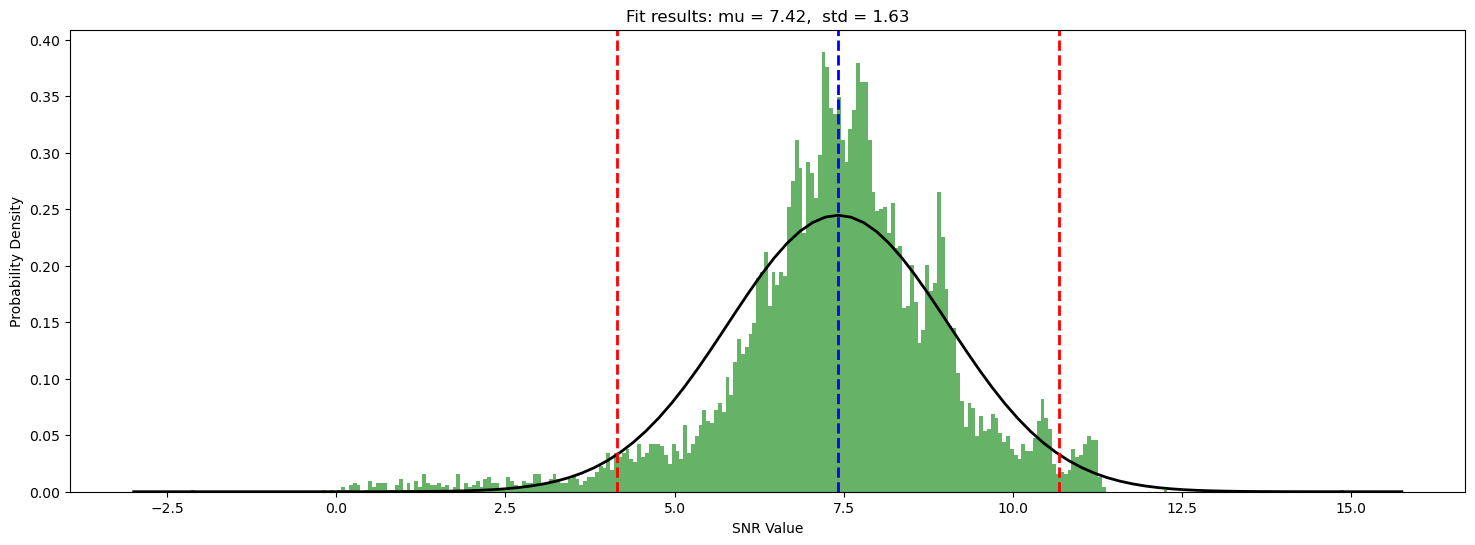

In [37]:
from scipy.stats import norm

# Plot the histogram
plt.figure(figsize=(18,6))
count, bins, ignored = plt.hist(snr_list, bins=300, density=True, alpha=0.6, color='g')

# Fit a normal distribution to the data
mu, std = norm.fit(snr_list)

# Plot the Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(mu , color='blue', linestyle='dashed', linewidth=2)
plt.axvline(mu - 2*std, color='r', linestyle='dashed', linewidth=2)
plt.axvline(mu + 2*std, color='r', linestyle='dashed', linewidth=2)

title = f"Fit results: mu = {mu:.2f},  std = {std:.2f}"
plt.title(title)

plt.xlabel('SNR Value')
plt.ylabel('Probability Density')
plt.show()

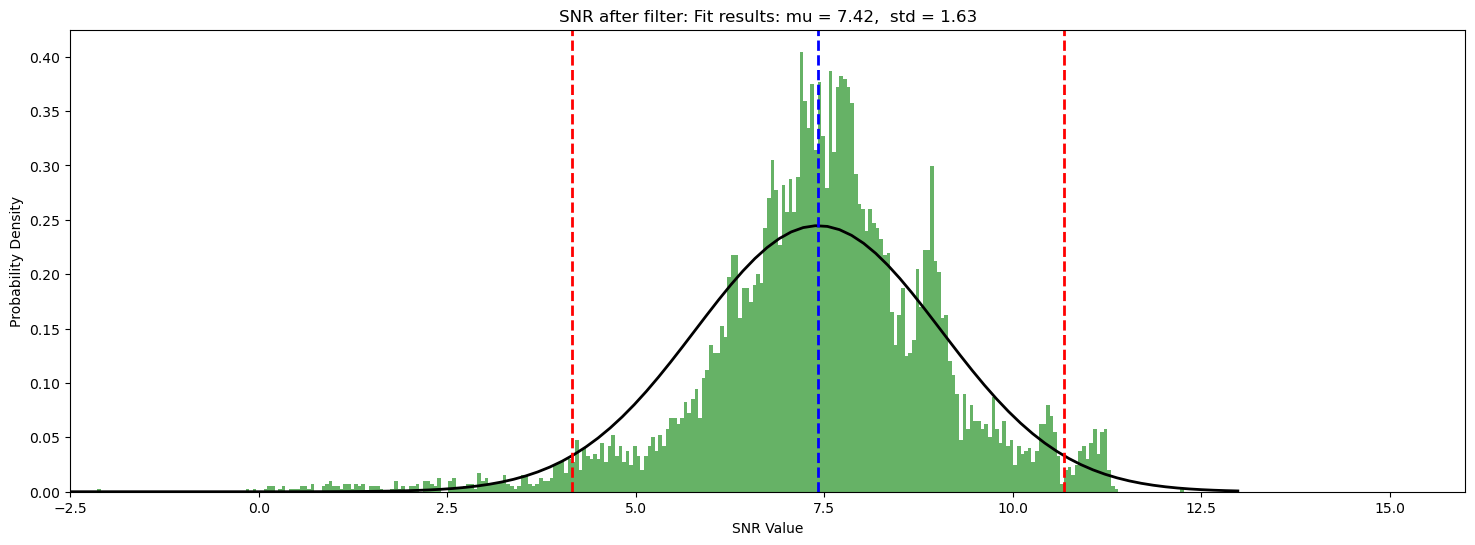

In [38]:
from scipy.stats import norm

# Plot the histogram
plt.figure(figsize=(18,6))
count, bins, ignored = plt.hist(chunks_df['snr'], bins=300, density=True, alpha=0.6, color='g')

# Fit a normal distribution to the data
mu, std = norm.fit(snr_list)

# Plot the Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(mu , color='blue', linestyle='dashed', linewidth=2)
plt.axvline(mu - 2*std, color='r', linestyle='dashed', linewidth=2)
plt.axvline(mu + 2*std, color='r', linestyle='dashed', linewidth=2)
plt.xlim((-2.5,16))
title = f"SNR after filter: Fit results: mu = {mu:.2f},  std = {std:.2f}"
plt.title(title)

plt.xlabel('SNR Value')
plt.ylabel('Probability Density')
plt.show()

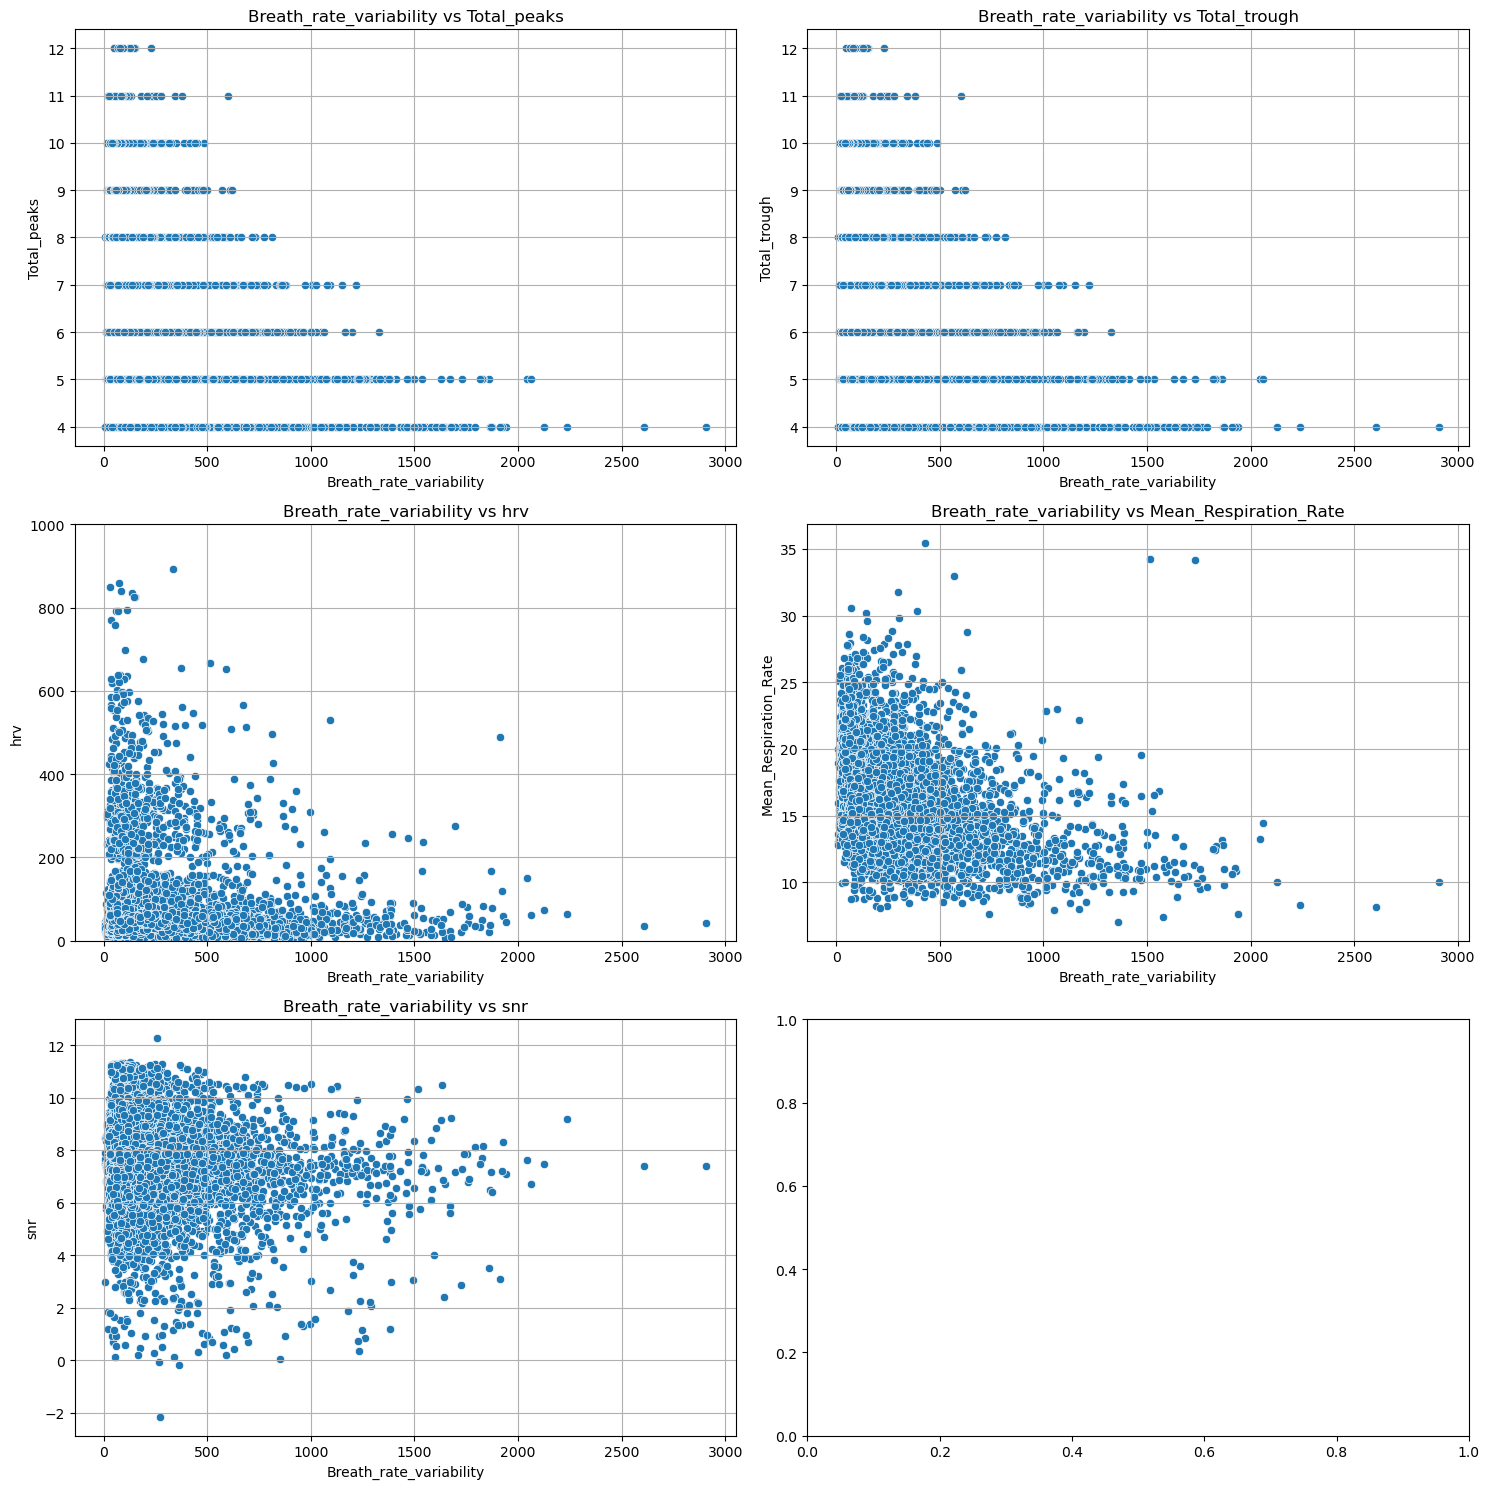

In [39]:
import seaborn as sns
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Define the columns to plot against Breath_rate_variability
columns_to_plot = ['Total_peaks', 'Total_trough', 'hrv', 'Mean_Respiration_Rate','snr']

# Iterate over the columns and create a scatter plot with a regression line
for ax, col in zip(axes.flatten(), columns_to_plot):
    sns.scatterplot(x='Breath_rate_variability', y=col, data=chunks_df, ax=ax)
    ax.set_title(f'Breath_rate_variability vs {col}')
    ax.set_xlabel('Breath_rate_variability')
    ax.set_ylabel(col)
    ax.grid()
    if col == 'hrv':
        ax.set_ylim((0,1000))
    
plt.tight_layout()
plt.show()

# Modeliing

In [40]:
# Drop rows where 'Mean Respiration Rate' is NaN
chunks_df = chunks_df.dropna(subset=['Mean_Respiration_Rate'])

# Convert 'ecg' column to a 3D numpy array
X = np.array(chunks_df['ecg'].tolist())
y = chunks_df['Mean_Respiration_Rate'].values

# Normalize each ECG chunk individually and handle NaNs
X_normalized = np.zeros_like(X)
for i in range(X.shape[0]):
    mean = np.mean(X[i])
    std = np.std(X[i])
    if std == 0:  # Avoid division by zero
        std = 1
    X_normalized[i] = (X[i] - mean) / std

# Identify rows with NaNs in the normalized data
nan_rows = np.isnan(X_normalized).any(axis=1)

# Remove rows with NaNs
X_normalized = X_normalized[~nan_rows]
y = y[~nan_rows]
cleaned_chunks_df = chunks_df[~nan_rows]
# Check again for NaN values in normalized data
print(f"NaN in X_normalized after cleaning: {np.isnan(X_normalized).sum()}, Inf in X_normalized: {np.isinf(X_normalized).sum()}")

NaN in X_normalized after cleaning: 0, Inf in X_normalized: 0


In [41]:
# Calculate the 2.5th and 97.5th percentiles
lower_percentile = np.percentile(y, 0.5)
upper_percentile = np.percentile(y, 99.5)



# Verify the clipping
print(f"1th percentile: {lower_percentile}")
print(f"99th percentile: {upper_percentile}")
print(f"Before clipping: min = {y.min()}, max = {y.max()}")
# Clip the values in y_train
y = np.clip(y, lower_percentile, upper_percentile)
print(f"After clipping: min = {y.min()}, max = {y.max()}")

# Continue with training the model using y_train_clipped

1th percentile: 9.069237711173686
99th percentile: 26.550882723541804
Before clipping: min = 7.04759225072079, max = 35.42373570432784
After clipping: min = 9.069237711173686, max = 26.550882723541804


In [42]:
from sklearn.model_selection import train_test_split

# Split the data by subjects
subjects = cleaned_chunks_df['subject_id'].unique()

# First, split subjects into training + validation, and test subjects
train_val_subjects, test_subjects = train_test_split(subjects, test_size=0.25, random_state=42)

# Now split the training + validation subjects to create a training set and validation set
train_subjects, val_subjects = train_test_split(train_val_subjects, test_size=0.15, random_state=42)

# Create boolean masks for train, validation, and test subjects
train_mask = cleaned_chunks_df['subject_id'].isin(train_subjects)
val_mask = cleaned_chunks_df['subject_id'].isin(val_subjects)
test_mask = cleaned_chunks_df['subject_id'].isin(test_subjects)

# Use these masks to create the actual train, validation, and test datasets
train_data = cleaned_chunks_df[train_mask]
val_data = cleaned_chunks_df[val_mask]
test_data = cleaned_chunks_df[test_mask]

# Now you have train, validation, and test datasets based on the subjects


In [43]:
# Apply the masks to create train, validation, and test sets
X_train = np.expand_dims(X_normalized[train_mask], 2)
y_train = y[train_mask] 
X_val = np.expand_dims(X_normalized[val_mask], 2)
y_val = y[val_mask]
X_test = np.expand_dims(X_normalized[test_mask], 2)
y_test = y[test_mask]

# Print shapes of the datasets to verify
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (5360, 7500, 1)
X_val shape: (1140, 7500, 1)
X_test shape: (1839, 7500, 1)
y_train shape: (5360,)
y_val shape: (1140,)
y_test shape: (1839,)


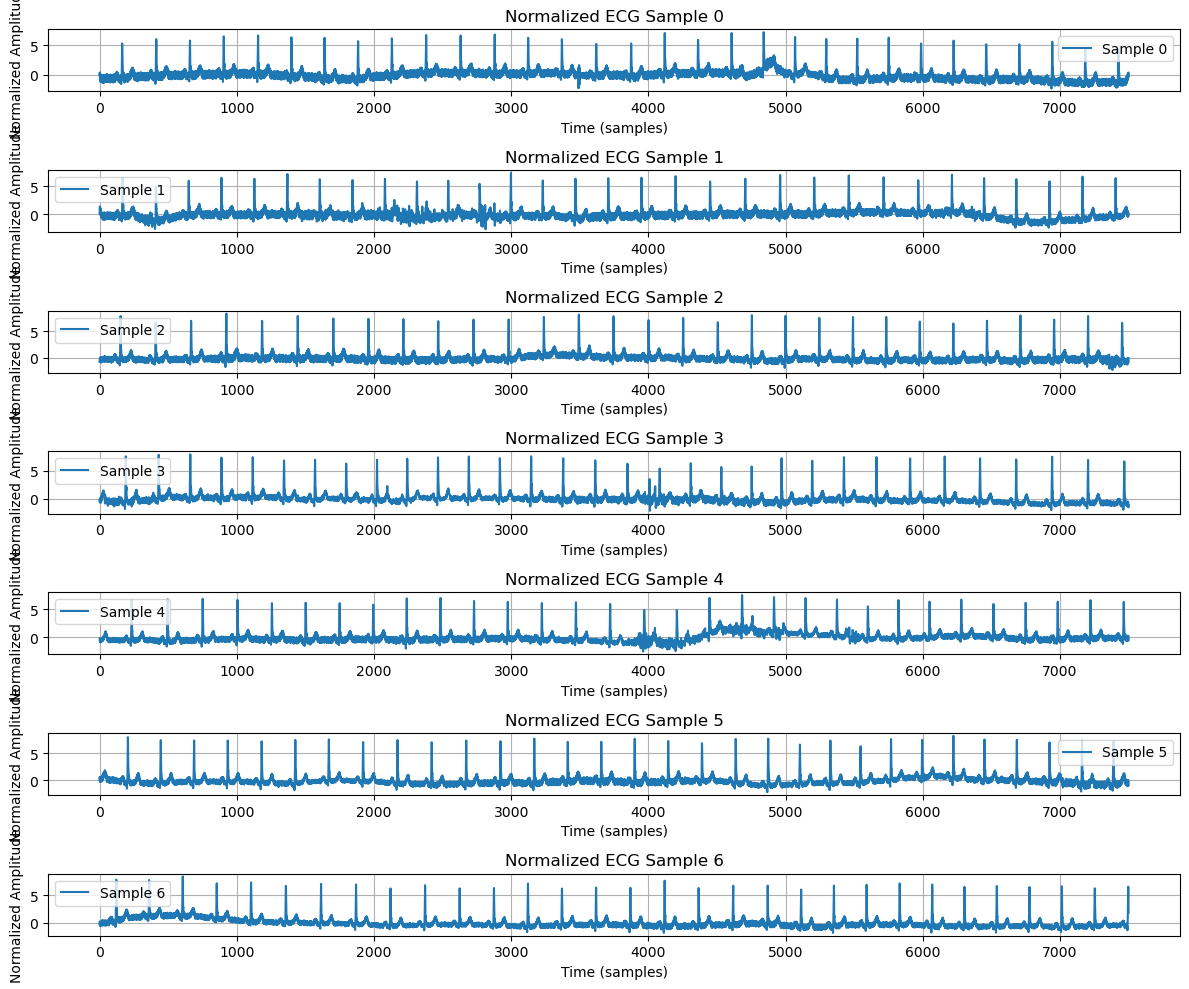

In [44]:
# Plot the first few samples of normalized ECG data in separate subplots
num_samples_to_plot = 7  # Number of samples to plot
fig, axs = plt.subplots(num_samples_to_plot, 1, figsize=(12, 10))

for i in range(num_samples_to_plot):
    axs[i].plot(X_normalized[i], label=f'Sample {i}')
    axs[i].set_title(f'Normalized ECG Sample {i}')
    axs[i].set_xlabel('Time (samples)')
    axs[i].set_ylabel('Normalized Amplitude')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [45]:
len(y_test)

1839

In [46]:
len(y_train)

5360

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = tf.keras.Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)  # Output layer for regression
])

2024-07-08 16:17:13.628028: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 16:17:13.644593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 16:17:13.667650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 16:17:13.667673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 16:17:13.683018: I tensorflow/core/platform/cpu_feature_gua

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_absolute_error', metrics=['mae'])

# Print the model summary
model.summary()

# Train the model with the validation data
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_val, y_val))

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model with MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")


In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [ ]:
from scipy.stats import pearsonr, linregress

# Calculate the Pearson correlation coefficient
correlation, p_value = pearsonr(y_test, y_pred.flatten())
print(f"Pearson Correlation: {correlation}")
print(f"P-value: {p_value}")

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred.flatten(), alpha=0.6, edgecolors='w', linewidth=0.5, label='Data points')

# Calculate the regression line
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred.flatten())
regression_line = slope * y_test + intercept
plt.plot(y_test, regression_line, color='red', linewidth=2, label='Regression line')

plt.title('Actual vs Predicted Mean Respiration Rates')
plt.xlabel('Actual Mean Respiration Rate')
plt.ylabel('Predicted Mean Respiration Rate')
plt.grid(True)
plt.legend()

# Add text box with correlation and p-value
textstr = f'Pearson Correlation: {correlation:.2f}\nP-value: {p_value:.2e}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.25, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
               verticalalignment='top', bbox=props)

plt.show()


In [ ]:
# Plot a histogram of the predicted mean respiration rates
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=30, edgecolor='black')
plt.title('Histogram of Predicted Mean Respiration Rates')
plt.xlabel('Predicted Mean Respiration Rate')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Shuffle and select a few examples from the test set
num_examples_to_plot = 5
indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)
selected_indices = indices[:num_examples_to_plot]

# Plot the selected examples from the test set
fig, axs = plt.subplots(num_examples_to_plot, 1, figsize=(12, 15))

for i, idx in enumerate(selected_indices):
    axs[i].plot(X_test[idx].flatten(), label='ECG Signal')
    axs[i].set_title(f'ECG Signal - Test Sample {idx}')
    axs[i].set_xlabel('Time (samples)')
    axs[i].set_ylabel('Normalized Amplitude')
    axs[i].legend(loc='upper right')
    axs[i].text(0.5, 0.95, f'Actual Mean Respiration Rate: {y_test[idx]:.2f}', horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)
    axs[i].text(0.5, 0.85, f'Predicted Mean Respiration Rate: {y_pred[idx][0]:.2f}', horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)
    axs[i].grid(True)

plt.tight_layout()
plt.show()